<a href="https://colab.research.google.com/github/ahirsch-github/flight-price-prediction/blob/2.0/flight_price_prediction_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flight Price Prediction #

## Introduction ##

Traveling by air is a common practice for many people around the globe, and the cost of air travel is a major factor in travel planning. For a given route, airfares can fluctuate significantly over time due to a variety of factors, such as demand, seasonality, and airline pricing strategies. This can lead to a common predicament for travelers: should they purchase their tickets now, or wait in the hopes of a price drop?

The aim of this project is to build a machine learning model that can help resolve this predicament. The model will predict whether it is optimal to purchase the ticket now or wait for a potential price drop.

The dataset used in this notebook is provided by Prof. Dr. Martin Spott and Manu Mutthatu.
It contains flight data from 2019 for the following routes:
-   London Stansted and Berlin Schönefeld
-   London Stansted and Frankfurt

This task is a practical application of machine learning that can provide valuable insights for both travelers and businesses in the travel industry. By predicting the optimal time to purchase a flight ticket, one can potentially save money and make travel planning less stressful. For businesses, this model can be used to build a buisness plan, to recommend the best time to purchase tickets to customers, or to optimize pricing strategies.


---



This notebook is organized as follows:
1. Load the data
2. Data Exploration and Feature Engineering
3. Prepare the Data for Model Training
4. Model Selection
5. Make Predictions

## Load the data ##

In this section, we will load the necessary Python libraries and the dataset we will be working with. This dataset, stored in a CSV file, is seperated in a train and a test dataset, each containing information about flight price requests. The test dataset is used to finally evaluate the performance of the model we will train on the train dataset. So in this notebook we will mostly use the train dataset and only use the test dataset to create a final prediction based on the trained model.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import sklearn
import xgboost as xgb

from datetime import date
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve

pd.options.mode.chained_assignment = None

In [2]:
# read in the data
orig_df_train = pd.read_csv('train_set.csv')
orig_df_test = pd.read_csv('test_set.csv')

## Data Exploration and Feature Engineering ##

In the first step in this workflow we delve into the dataset to understand the relationships and trends between different features. This phase is crucial as it provides insights into the data, which can guide our model training later. We will perform several tasks, including:

- Reviewing the first rows of the dataset for a general overview
- Investigating the data types of each feature to comprehend the nature of data we are dealing with
- Checking for duplicate and missing values and considering strategies to handle them
- Computing basic statistical metrics (mean, standard deviation, quartiles) to understand the distribution of data
- Dig deeper into the data by plotting histograms and other charts for each feature to provide visual insights
- Creating new features from the existing data with the aim to improve the predictive power of the model. This might involve transforming, combining, deriving, or otherwise manipulating data to better utilize the information they hold. For instance, it might be useful to extract the day of the week from the flight date, as weekend flights might be more expensive than weekday flights
- Handling categorical features as most machine learning algorithms can only handle numerical data

After investigating and creating new features, we will look at the correlations among the features. This will help us understand if some features are redundant due to high correlations with other features or if some features are highly correlated with the target variable and can be used to predict it.


### Get to know the data ###

In [3]:
# make a copy of the data
df_train_copy = orig_df_train.copy()

# check the data
df_train_copy.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


The data contains the following columns:
-   *index*: index of the row
-   *request_date*: date when the request was made
-   *flight_date*: date when the flight took place
-   *departure_hour*: hour when the flight departed
-   *flight_unique_id*: unique id for each flight
-   *route_abb*: abbreviation of the route
-   *price_in_eur*: price of the flight in euro
-   *min_future_price_in_euro*: minimum price of the flight in euro for all future request dates
-   *buy*: 1 if the flight should now be bought, 0 if one should wait

In [4]:
# check the number of rows and columns
df_train_copy.shape

(83624, 9)

The data contains 83624 rows and 9 columns.

In [5]:
# check the data types
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83624 entries, 0 to 83623
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    83624 non-null  int64  
 1   Request_Date             83624 non-null  object 
 2   Flight_Date              83624 non-null  object 
 3   Departure_hour           83624 non-null  int64  
 4   flight_unique_id         83624 non-null  object 
 5   route_abb                83624 non-null  object 
 6   Price_In_Eur             83624 non-null  float64
 7   min_future_price_in_Eur  83624 non-null  float64
 8   buy                      83624 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.7+ MB


The data types are correct, except for the date columns. We will deal with that later.

In [6]:
# check if there are any missing values
df_train_copy.isnull().sum()

index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64

Luckily, there are **no missing values** in the data.

In [7]:
# check for duplicates
df_train_copy.duplicated().sum()

0

There are **no duplicates** in the data.

Next, we will search for **outliers** in the data. Therefore we look at the z-score of each value in the data. The z-score is the number of standard deviations away from the mean a data point is. We will remove all data points that have a z-score bigger them 3, because these are considered as outliers, because the standard deviation differ too much from the mean.

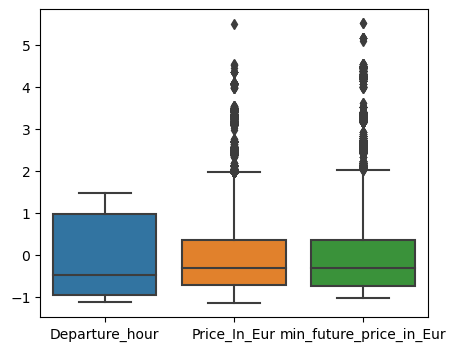

In [8]:
## Get the z-scores and create boxplots for the numerical columns

# Calculate z-scores for the numerical columns
df_train_num = df_train_copy[['Departure_hour', 'Price_In_Eur', 'min_future_price_in_Eur']]
z_scores_train = stats.zscore(df_train_num)

# Calculate z-scores for the numerical columns
z_scores_test = stats.zscore(df_train_num[['Departure_hour', 'Price_In_Eur', 'min_future_price_in_Eur']])

# Create Boxplots for the z-scores
plt.figure(figsize=(5, 4))
sns.boxplot(data=z_scores_train);

In [9]:
## Get the data considered as outliers

# Get the rows with z-scores > 3
outliers_train = np.where(z_scores_train > 3)

# Get the rows in the df_train_copy that contain outliers
df_train_copy_outlier_rows = df_train_copy.iloc[outliers_train[0]]

# Check the proportion of outliers
print(len(df_train_copy_outlier_rows)/len(df_train_copy))

0.04889744570936573


There are around 4.9% outliers in the data. Before we remove or transform them, we need to check if the outliers are reasonable or not. If they are reasonable, we can keep them. If they are not reasonable, we can remove them or transform them. Therefore we look at some features and their relationship with the outliers.

In [10]:
# Check the distribution of the route_abb column for the outliers
df_train_copy_outlier_rows['route_abb'].value_counts()

STN-SXF    1899
SXF-STN    1479
STN-FRA     393
FRA-STN     318
Name: route_abb, dtype: int64

In [11]:
# Check the distribution of Departure_hour column for the outliers
df_train_copy_outlier_rows['Departure_hour'].value_counts()

19    1247
6      767
18     667
7      666
10     349
22     285
8       68
21      40
Name: Departure_hour, dtype: int64

It seems that the outliers are not random but are associated with specific routes and departure hours. This suggests that they might be extreme but valid data points. Therefore we will not remove or replace them.

In [12]:
# check the noise in the data
df_train_copy.describe()

,index,Departure_hour,Price_In_Eur,min_future_price_in_Eur,buy
count,83624.000000,83624.000000,83624.000000,83624.000000,83624.000000
mean,41812.500000,12.969889,71.965080,56.593014,0.223835
std,24140.313792,6.177936,54.788483,46.126909,0.416815
min,1.000000,6.000000,8.990000,8.990000,0.000000
25%,20906.750000,7.000000,32.770000,22.270000,0.000000
50%,41812.500000,10.000000,55.080000,41.890000,0.000000
75%,62718.250000,19.000000,91.790000,73.430000,0.000000
max,83624.000000,22.000000,372.960000,311.090000,1.000000


-  *Departure_hour*: earliest departure hour is 6 (6 am), latest departure hour is 22 (10pm). Mean is 13 (1 pm).
-  *Price_In_Eur*: minimum price is 8.99€, maximum price is 372.96€. Average price is 72€.
-  *min_future_price_in_Eur*: minimum minimum future price is 8.99€, maximum minimum future price is 311.09€. Average minimum future price is 57€.
-  *buy*: is a boolean value. Therefore the description is not very meaningful except we can see, that more flights in the data were recommended to wait than to buy.

Now we want to dig deeper into the data and see if we can find any interesting insights that we can use to improve our model. Therefore we will have a look at each feature. Those include:   
- *Price_In_Eur*             
- *min_future_price_in_Eur*  
- *Request_Date*               
- *Flight_Date*                
- *Departure_hour*             
- *route_abb*                 
- *buy*                  
- *flight_unique_id*                 

### Price in Eur ###

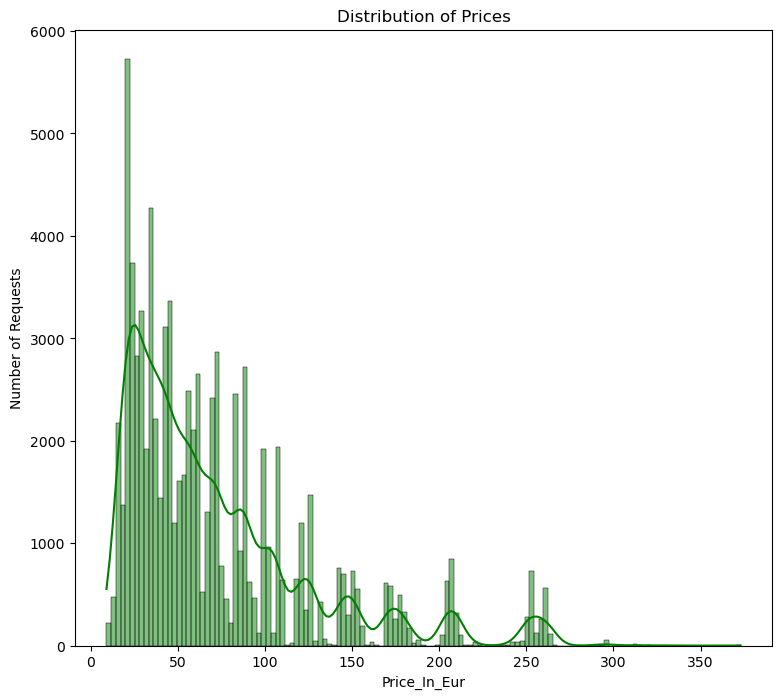

In [13]:
# check the distribution of Price in Euro
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Price_In_Eur'], color='g', kde=True);

plt.title('Distribution of Prices')
plt.ylabel('Number of Requests')
plt.show()

The prices seem to be quite evenly distributed. There are fluctuations in the higher prices that seem to be repeated. Also there seems to be some more expensive flights in prices around and above 350€.

### Min Future Price in Eur ###

*min_future_price_in_Eur* is a useful target variable for our model, if we want to train a regression model, because if this value is less then the current price, then we can say that it might be better to wait to buy the ticket. If this value is greater then the current price, then we can say that it might be better to buy the ticket now.

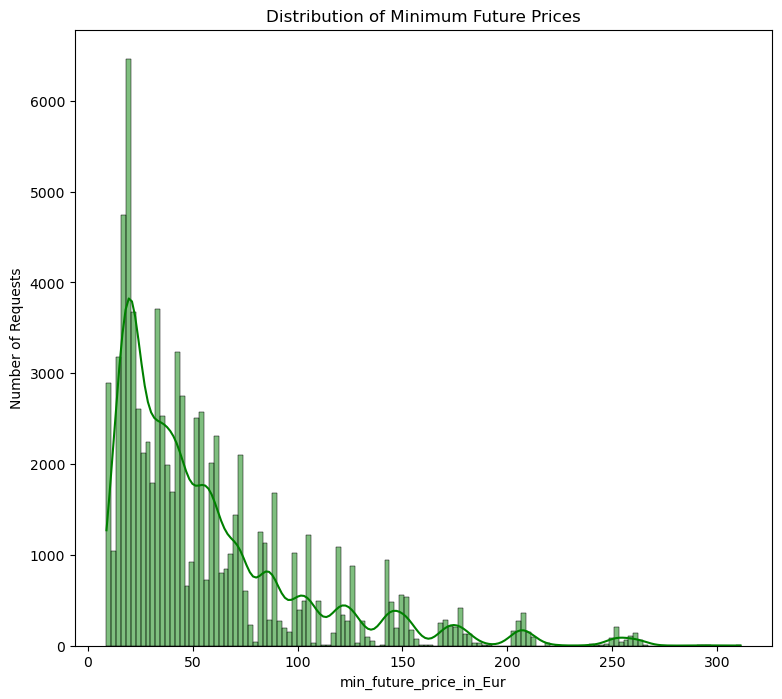

In [14]:
# check distribution of min_future_price_in_eur
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['min_future_price_in_Eur'], color='g', kde=True);

plt.title('Distribution of Minimum Future Prices')
plt.ylabel('Number of Requests')
plt.show()

The min_future_price_in_Eur distribution nearly looks exactly like the Price_in_Eur distribution. This is as expected, since the min_future_price_in_Eur is the minimum price (Price_In_Eur) of the flight in the future.

### Request Date ###

We already have seen, that Request_Date is of type object. Therefore we need to convert it to datetime format so that we can extract information like day or month from it.

In [15]:
# check the last date in the data
print(df_train_copy['Request_Date'].min())
print(df_train_copy['Request_Date'].max())

2019-06-03T11:00:00Z
2019-08-03T11:00:00Z


The data contains requests from 2019-06-03 to 2019-08-03.

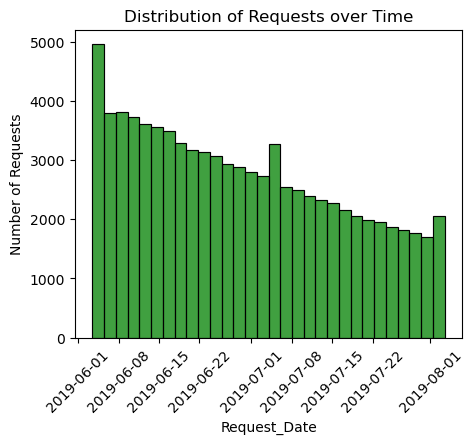

In [16]:
# check the distribution of the request date
# convert the request date to datetime
df_train_copy['Request_Date'] = pd.to_datetime(df_train_copy['Request_Date'])

plt.figure(figsize=(5, 4))
sns.histplot(df_train_copy['Request_Date'], color='g', bins=30);

plt.xticks(rotation=45);
plt.title('Distribution of Requests over Time')
plt.ylabel('Number of Requests')
plt.show()

The bars decrease in height over time, which means that the number of requests decrease over the given time period. This could be because there may be less demand in the later months. But more likely it could be due to the limited data, which only contains Requests from June to August.

Maybe it is useful for the model to know in which month the flight is taking place. So we will add a new column called *Request_Month* to the dataframe.

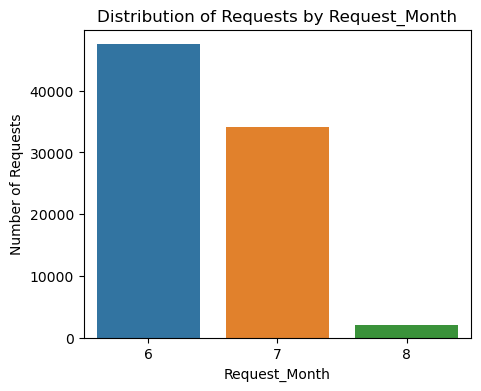

In [17]:
# Extract the month from the request date
df_train_copy['Request_Month'] = df_train_copy['Request_Date'].dt.month

# plot the request month
plt.figure(figsize=(5,4))
sns.countplot(x='Request_Month', data=df_train_copy);
plt.title('Distribution of Requests by Request_Month')
plt.ylabel('Number of Requests')
plt.show()

The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August.

Additionally it may be interesting to know, on which day of the week the request was made. This can be done by extracting the day of the week from the date of the request, we call this feature *Request_Day_Of_Week*. The day of the week is encoded as a number between 0 and 6, where 0 is Monday and 6 is Sunday.

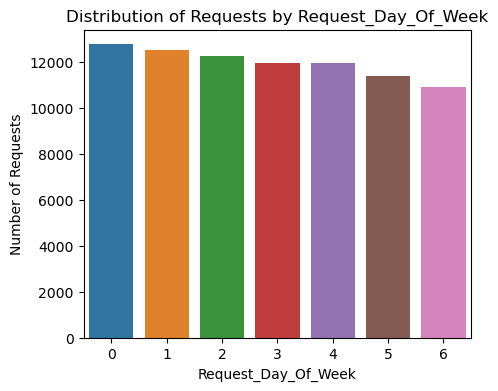

In [18]:
# Extract the day of the week from the request date
df_train_copy['Request_Day_Of_Week'] = df_train_copy['Request_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the request day of the week
plt.figure(figsize=(5, 4))
sns.countplot(x='Request_Day_Of_Week', data=df_train_copy)
plt.title('Distribution of Requests by Request_Day_Of_Week')
plt.ylabel('Number of Requests')
plt.show()

There are nearly the same amount of requests on each day of the week.

Also, maybe it is interesting to know if the request was made on a weekend or not. So we will create a new feature called *Request_is_Weekend* which will be 1 if the request was made on a weekend and 0 if it was made on a weekday.

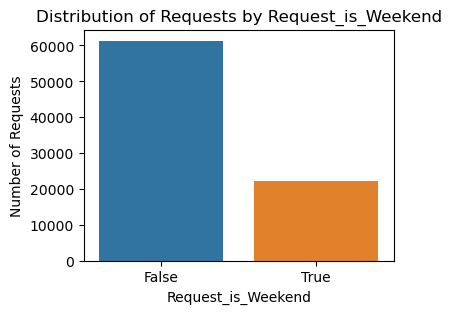

In [19]:
# create a new column to indicate if the request was made on a weekend
df_train_copy['Request_is_Weekend'] = df_train_copy['Request_Date'].dt.weekday >= 5

# plot the request is weekend
plt.figure(figsize=(4,3))
sns.countplot(x='Request_is_Weekend', data=df_train_copy)
plt.title('Distribution of Requests by Request_is_Weekend')
plt.ylabel('Number of Requests')
plt.show()

The *Request_Date* contains information regarding the time in which the request was made. With this information, we can create a new feature called *Request_Hour* which will contain the hour of the day in which the request was made.

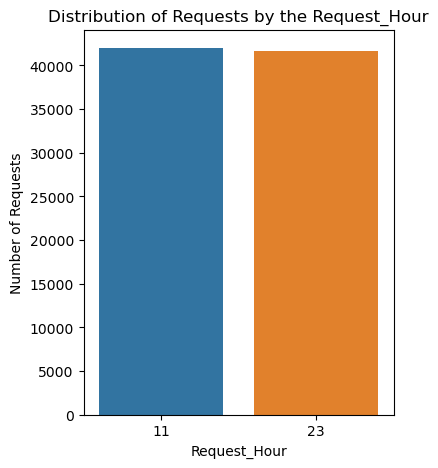

In [20]:
# extract the hour from the request date
df_train_copy['Request_Hour'] = df_train_copy['Request_Date'].dt.hour

# plot the request hour
plt.figure(figsize=(4,5))
sns.countplot(x='Request_Hour', data=df_train_copy)
plt.title('Distribution of Requests by the Request_Hour')
plt.ylabel('Number of Requests')
plt.show()

There were requests only at 11 (11 am) and at 23 (11 pm). Approximately the same number of requests were received at both times.

### Flight Date ###

Just like the *Request_Date* column, the *Flight_Date* column is also from type object. We need to convert it to datetime format.

In [21]:
# check the distribution of flight date
# convert the flight date to datetime
df_train_copy['Flight_Date'] = pd.to_datetime(df_train_copy['Flight_Date'])

In [22]:
# get the first and the last flight date
print(df_train_copy['Flight_Date'].min())
print(df_train_copy['Flight_Date'].max())

2019-06-05 00:00:00
2019-09-10 00:00:00


The first flight left on 2019-06-05 and the last flight on 2019-09-10.

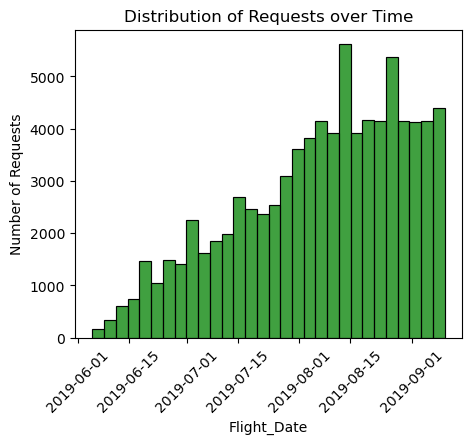

In [23]:
plt.figure(figsize=(5,4))
sns.histplot(df_train_copy['Flight_Date'], color='g', bins=30)
plt.xticks(rotation=45);
plt.title('Distribution of Requests over Time')
plt.ylabel('Number of Requests')
plt.show()

Like with Request_Date, we extract information to get the *Flight_Month*, *Flight_Day_Of_Week* and *Flight_is_Weekend*.

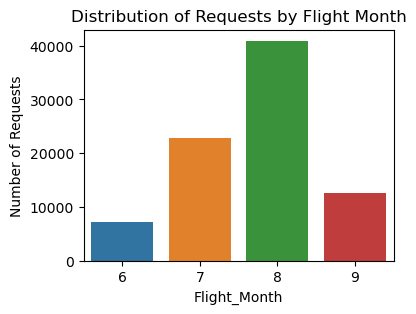

In [24]:
# Extract the month from the flight date
df_train_copy['Flight_Month'] = df_train_copy['Flight_Date'].dt.month

# plot the flight month
plt.figure(figsize=(4,3))
sns.countplot(x='Flight_Month', data=df_train_copy)
plt.title('Distribution of Requests by Flight Month')
plt.ylabel('Number of Requests')
plt.show()

Most flights depart in August, around half as many in July and only a few in September and even less in June.

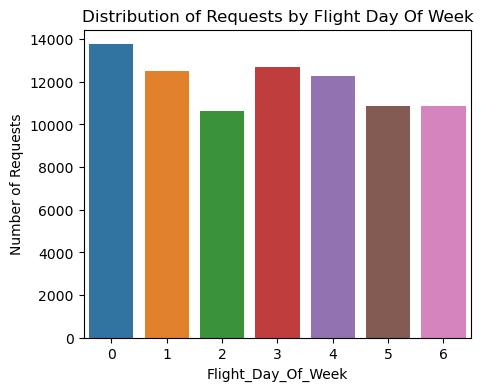

In [25]:
# Extract the day of the week from the flight date
df_train_copy['Flight_Day_Of_Week'] = df_train_copy['Flight_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the flight day of the week
plt.figure(figsize=(5,4))
sns.countplot(x='Flight_Day_Of_Week', data=df_train_copy)
plt.title('Distribution of Requests by Flight Day Of Week')
plt.ylabel('Number of Requests')
plt.show()

The number of requests fluctuate for the different flight days of the week, meaning on some weekdays there seem to be more requests than on others.

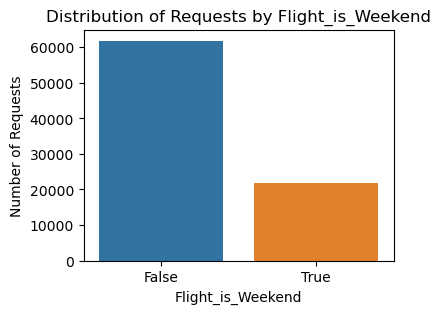

In [26]:
# create a new column to indicate if the flights are on a weekend
df_train_copy['Flight_is_Weekend'] = df_train_copy['Flight_Date'].dt.weekday >= 5

# plot the request is weekend
plt.figure(figsize=(4,3))
sns.countplot(x='Flight_is_Weekend', data=df_train_copy)
plt.title('Distribution of Requests by Flight_is_Weekend')
plt.ylabel('Number of Requests')
plt.show()

In [27]:
# check data types of flight date and request date
print(df_train_copy['Flight_Date'].dtype)
print(df_train_copy['Request_Date'].dtype)

# remove the timezone from the request date
df_train_copy['Request_Date'] = df_train_copy['Request_Date'].dt.tz_convert(None)

# check dates, where the flight date is before the request date
flight_date_before_request_date = df_train_copy[df_train_copy['Flight_Date'] < df_train_copy['Request_Date']]

print(flight_date_before_request_date.shape[0])

datetime64[ns]
datetime64[ns, UTC]
0


The Flight Dates seems to be valid since there are no Flights where the *Flight_Date* is before the *Request_Date*.

### New Feature: Days between request date and flight date ###

The time between the Request and the departure of the flight might be an indicator for the current price. Therefore we create a new column *days_between_request_and_flight*.

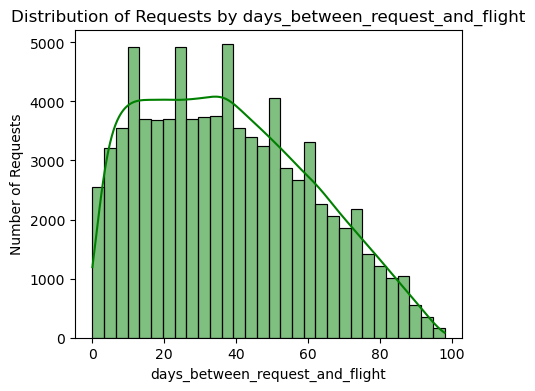

count    83624.000000
mean        37.913601
std         22.859873
min          0.000000
25%         19.000000
50%         36.000000
75%         55.000000
max         98.000000
Name: days_between_request_and_flight, dtype: float64


In [28]:
# check the distribution of the number of days between request date and flight date
df_train_copy['days_between_request_and_flight'] = (df_train_copy['Flight_Date'] - df_train_copy['Request_Date']).dt.days

plt.figure(figsize=(5,4))
sns.histplot(df_train_copy['days_between_request_and_flight'], color='g', kde=True, bins=30)
plt.title('Distribution of Requests by days_between_request_and_flight')
plt.ylabel('Number of Requests')
plt.show()

# get the min, max, mean and median of the number of days between request date and flight date
print(df_train_copy['days_between_request_and_flight'].describe())

There are between 0 and 98 days between the request date and the flight date.

### Departure Hour ###

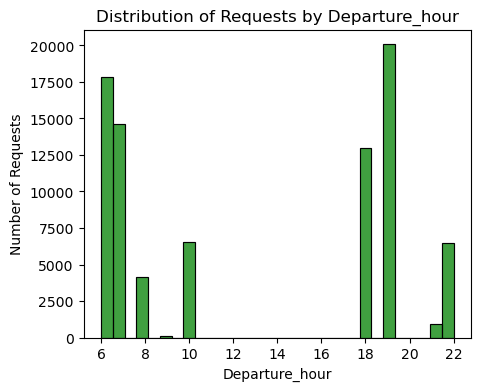

In [29]:
# check the distribution of Departure hour
plt.figure(figsize=(5,4))
sns.histplot(df_train_copy['Departure_hour'], color='g')
plt.title('Distribution of Requests by Departure_hour')
plt.ylabel('Number of Requests')
plt.show()

The earliest flights depart at 6, the latest at 22. Most flights seem to depart in the morning or in the evening. There are no flights departing in the afternoon between 12 and 16.

### New Feature: Is Holiday ###

As it is possible that the price of flights is higher on bank holidays or during school holidays, we will look at both of these information.

#### Bank Holidays ####

The data for the bank holidays is taken from the python package holidays. The data contains bank holidays for different countries. The data for holidays in germany and uk is then merged with the data from the flights.

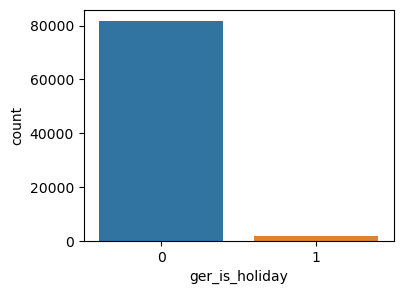

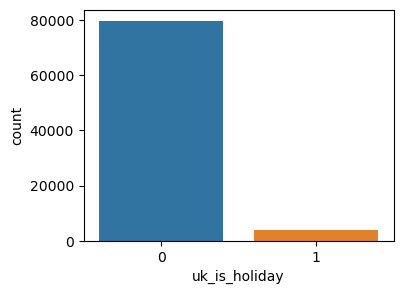

In [30]:
import holidays

ger_holidays = holidays.GR()
# create a function to check if a date is a holiday in germany
def is_holiday_ger(date):
    if date in ger_holidays:
        return 1
    else:
        return 0

# create a new column with the holiday information
df_train_copy['ger_is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_ger)

# check the distribution of is_holiday
plt.figure(figsize=(4,3))
sns.countplot(x='ger_is_holiday', data=df_train_copy);


uk_holidays = holidays.UK()
# create a function to check if a date is a holiday in the UK
def is_holiday_uk(date):
    if date in uk_holidays:
        return 1
    else:
        return 0

# create a new column with the holiday information
df_train_copy['uk_is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_uk)

# check the distribution of is_holiday
plt.figure(figsize=(4,3))
sns.countplot(x='uk_is_holiday', data=df_train_copy);

There are only a few bank holidays in the data (a few in germany, none in the uk) so the two holiday columns for the different countries are combined to one column. The new column contains the information if the flight is on a bank holiday (it doesn't matter if in the departure or arrival country) or not.

In [31]:
# function to check if a date is a holiday in the UK or Germany
def is_bank_holiday_uk_ger(date):
    if date in ger_holidays or date in uk_holidays:
        return 1
    else:
        return 0

# merge the two holiday columns into one
df_train_copy['is_bank_holiday'] = df_train_copy['Flight_Date'].apply(is_bank_holiday_uk_ger)

# drop the two seperate bank holiday columns for ger and uk
df_train_copy.drop(['ger_is_holiday', 'uk_is_holiday'], axis=1, inplace=True)

#### School holidays ####

Flight prices may be higher during the school holidays, because more people have the opportunity to go on vacation. Because the flights arrival and departure airports are in Germany and UK, the school holidays for these countries are added to the data [1, 2]. Because in Germany the school holidays are different for each state, the school holidays for the state of the departure airport are added to the data, meaning Berlin (and Brandenburg because it is close to Berlin) and Nordrhein-Westfalen (NRW). Only if the flight is in the school holidays of the departure or arrival airport, the flight is marked as a flight during the school holidays.

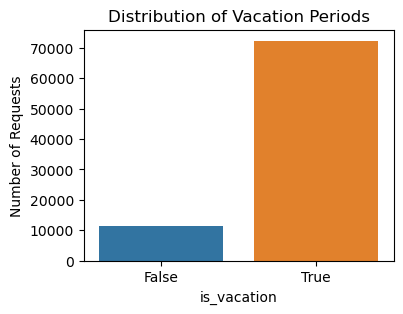

In [32]:
def is_vacation(df):
    vacations = [
        {'start': '2019-07-15', 'end': '2019-08-27', 'airports': ['FRA']},  # NRW
        {'start': '2019-05-31', 'end': '2019-06-11', 'airports': ['SXF']},  # Berlin
        {'start': '2019-06-20', 'end': '2019-08-02', 'airports': ['SXF']},  # Berlin
        {'start': '2019-06-20', 'end': '2019-08-03', 'airports': ['SXF']},  # Brandenburg
        {'start': '2019-07-15', 'end': '2019-09-06', 'airports': ['STN']}   # UK
    ]

    # Convert the start and end dates to datetime
    for vacation in vacations:
        vacation['start'] = pd.to_datetime(vacation['start'])
        vacation['end'] = pd.to_datetime(vacation['end'])

    # Extract the Departure_airport and Arrival_airport from the route_abb column
    df['departure_airport'] = df['route_abb'].str[:3]
    df['arrival_airport'] = df['route_abb'].str[-3:]

    # Initialize a new column 'is_vacation' with False
    df['is_vacation'] = False

    # Set 'is_vacation' to True if the flight date is within any of the vacation periods
    # and the origin or destination airport is associated with the vacation
    for vacation in vacations:
        df.loc[(df['Flight_Date'] >= vacation['start']) & (df['Flight_Date'] <= vacation['end']) &
               ((df['departure_airport'].isin(vacation['airports'])) | (df['arrival_airport'].isin(vacation['airports']))),
               'is_vacation'] = True

    # drop the departure and arrival airport columns
    df.drop(['departure_airport', 'arrival_airport'], axis=1, inplace=True)

    return df['is_vacation']

df_train_copy['is_vacation'] = is_vacation(df_train_copy)

# plot the distribution of is_vacation
plt.figure(figsize=(4, 3))
sns.countplot(x='is_vacation', data=df_train_copy)
plt.title('Distribution of Vacation Periods')
plt.ylabel('Number of Requests')
plt.show()

There seems to be a lot more requests for flights during the vacation periods. This is probably because people are more likely to travel during the vacation periods and the date ranges only for the months July till September, which is in most countries the vacation period.

#### Merge bank holidays and school holidays ####

Because bank holidays and school holidays are sematically similar, we combine the features *is_bank_holiday* and *is_vacation* into one feature *is_holiday* and drop the other two seperate features.

In [33]:
# merge the columns 'is_holiday' and 'is_vacation' into one column
df_train_copy['is_holiday'] = df_train_copy['is_bank_holiday'] | df_train_copy['is_vacation']

# drop the column 'is_vacation'
df_train_copy.drop('is_vacation', axis=1, inplace=True)
# drop the column 'is_bank_holiday'
df_train_copy.drop('is_bank_holiday', axis=1, inplace=True)

### Route Abb ###

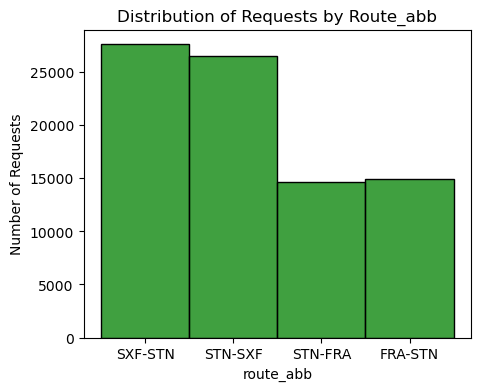

In [34]:
# check the distribution of route abb
plt.figure(figsize=(5, 4))
sns.histplot(df_train_copy['route_abb'], color='g')
plt.title('Distribution of Requests by Route_abb')
plt.ylabel('Number of Requests')
plt.show()

The data contains 2 routes: SXF-STN and STN-FRA additionally for both of those routes there are flights in both directions. There are a little more than 10000 more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA.

It may be helpful to extract the departure and arrival airport from the route and create a new feature for it, so we can later see if the airport has an impact on the buy decision
.

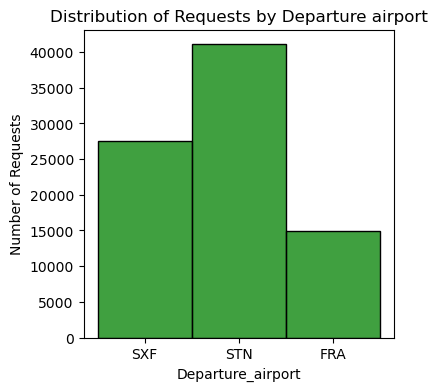

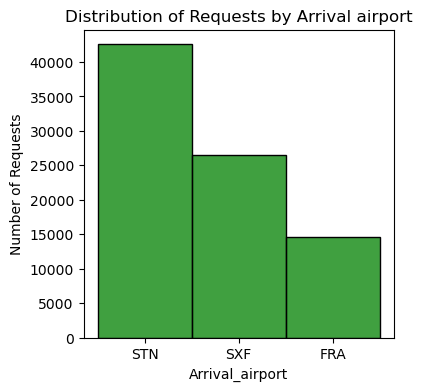

In [35]:
# Extract the departure and arrival airports from the route_abb column
df_train_copy['Departure_airport'] = df_train_copy['route_abb'].str.split('-').str[0]
df_train_copy['Arrival_airport'] = df_train_copy['route_abb'].str.split('-').str[1]

# check the distribution of Departure airport
plt.figure(figsize=(4, 4))
sns.histplot(df_train_copy['Departure_airport'], color='g')
plt.title('Distribution of Requests by Departure airport')
plt.ylabel('Number of Requests')
plt.show()

# check the distribution of Arrival airport
plt.figure(figsize=(4, 4))
sns.histplot(df_train_copy['Arrival_airport'], color='g')
plt.title('Distribution of Requests by Arrival airport')
plt.ylabel('Number of Requests')
plt.show()

Most flights seem to depart from or arrive at STN. The least common airport is FRA.

### Buy ###

The *buy* column is calculated with the columns *Price_In_Eur* and *min_future_price_in_Eur*. If the *min_future_price_in_Eur* is lower than the *Price_In_Eur* the *buy* column is set to 1, otherwise to 0. This means it is a good target variable for a classification problem.

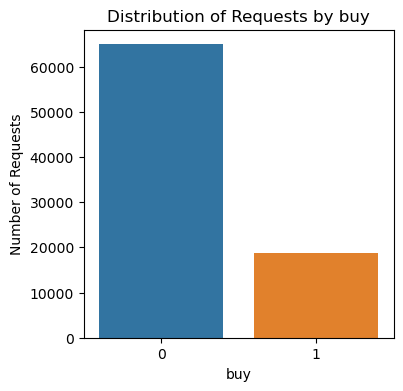

In [36]:
# check the distribution of buy
plt.figure(figsize=(4, 4))
sns.countplot(x='buy', data=df_train_copy)
plt.title('Distribution of Requests by buy')
plt.ylabel('Number of Requests')
plt.show()

There are more than three times more requests where the flight is currently not recommended to be bought than requests where the flight is recommended to be bought.

### Flight Unique Id ###

The flight_unique_id can tell us the number of requests recently made for each flight. Maybe this new feature is a good indicator to tell, if the price is going to increase or decrease. It could be that the price of an highly requestd flight is going up or down. Let's find out.

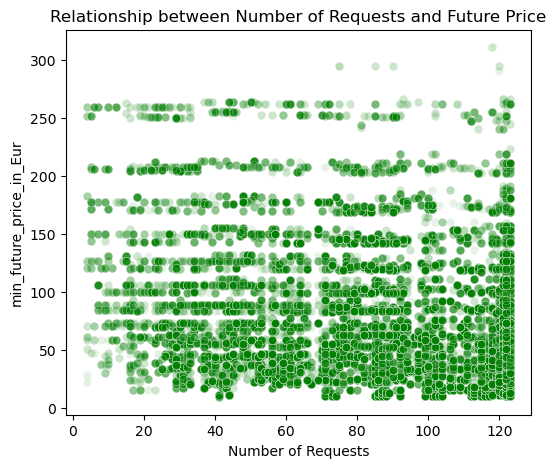

In [37]:
# check the number of requests for each flight
df_train_copy['num_requests'] = df_train_copy['flight_unique_id'].map(df_train_copy['flight_unique_id'].value_counts())

# plot the relationship between number of requests and price
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_train_copy, x='num_requests', y='min_future_price_in_Eur', alpha=0.1, color='g')
plt.title('Relationship between Number of Requests and Future Price')
plt.xlabel('Number of Requests')
plt.ylabel('min_future_price_in_Eur')
plt.show()

For some flights there seem to be a lot more requests than for others. It seems that the future price of a few flights that are relatively often requested is higher than from not so often requested flights. We investigate this correlation later on in this notebook when we look at the feature importance.

We can't use this feature for training, because it contains data, we don't have in practise. Therefore we will newly calculate the number of requests by using the rolling function to calculate the number of requests in the last 5 days.

In [38]:
def rolling_num_requests(data):
    # Sort the data by Flight_Date
    df = data.sort_values('Request_Date')

    # Calculate the number of requests in the last 5 days for each flight
    data['num_requests'] = data.groupby('flight_unique_id').rolling('5D', on='Request_Date')['Request_Date'].count().reset_index(drop=True)

    # Replace NaN values with the mean of the rest of the values in the column
    data['num_requests'].fillna(data['num_requests'].mean(), inplace=True)

    return data

df_train_copy = rolling_num_requests(df_train_copy)

Now we could use this feature for model training.

### New Feature: Rolling Mean Price ###


The current price trend may be a relevant information. If the price is currently relatively low, it may be better to buy the flight now. If the price is currently high compared to the rolling mean, it may be better to wait a little longer. Therefore we calculate the rolling mean of the price for the last 7 requests.

In [39]:
df_train_copy['rolling_mean_price'] = df_train_copy.groupby('flight_unique_id')['Price_In_Eur'].transform(lambda x: x.rolling(7, min_periods=1).mean())

Now we can look at the price trends over the time for the flights.

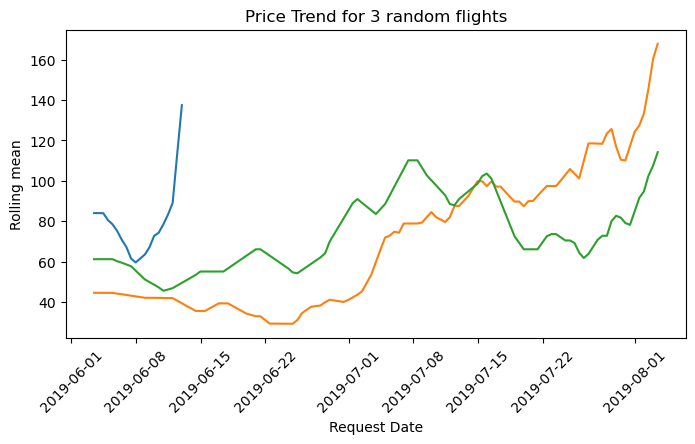

In [40]:
flight_ids = df_train_copy['flight_unique_id'].sample(3).values

plt.figure(figsize=(8, 4))

# Plot the price trend for each flight request
for flight_id in flight_ids:
    plt.plot(df_train_copy[df_train_copy['flight_unique_id'] == flight_id]['Request_Date'],
             df_train_copy[df_train_copy['flight_unique_id'] == flight_id]['rolling_mean_price'])
plt.title(f'Price Trend for 3 random flights')
plt.xlabel('Request Date')
plt.ylabel('Rolling mean')
plt.xticks(rotation=45)
plt.show()

### New feature: Price Increase Frequency ###

For the model, it could be useful to look at the price increase. I.e. determine how often the price has risen in the last 10 requests in order to see a trend, whether the price is currently rising or perhaps even falling.

In [41]:
df_train_copy['price_increase_frequency'] = df_train_copy.groupby('flight_unique_id')['Price_In_Eur'].transform(lambda x: (x.diff() > 0).rolling(10, min_periods=1).sum())

### New feature: Price difference ###

The difference between the current price and the average price for the same flight in the past could be another important parameter for the model. This allows statements on whether the price is currently very different from the average price. For example, if the price is currently much lower than the average price for this flight in past requests, it might make sense to buy the ticket now.

In [42]:
# Calculate the difference between the current price and the average price of the same flight in the past
grouped_prices = df_train_copy.groupby('flight_unique_id')['Price_In_Eur'].transform('mean')
df_train_copy['price_difference'] = df_train_copy['Price_In_Eur'] - grouped_prices

### Summary ###

The data exploration so far showed that:
-  There are no duplicates in the data
-  There are no missing values in the data
-  *Request_date* and *Flight_date* are of type object, but should be of type datetime. Request date contained the timezone information, which was removed. The data was then converted to datetime.
-  *Price_In_Eur*:
    -  The distribution is right-skewed, with most of the flight prices being less than 100 EUR. There are also some flights with prices up to around 375 EUR, but these are less common.
-  *Min_future_price_in_Eur*:
    -  The distribution is similar to that of 'Price_In_Eur', being right-skewed with most of the minimum future prices being less than 100 EUR. There are also some flights with minimum future prices up to around 300 EUR, but these are less common.
-  *Request_Date*:
    -  The data contains *Request_date*s from 2019-06-03 to 2019-08-03. There are no outliers. <br>
    The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August. <br>
    There are nearly the same amount of requests on each day of the week. There are no outliers.
-  *Flight_Date*:
    -  The first *Flight_date* is on 2019-06-05 and the last flight on 2019-09-10. There are no outliers.
-  *Departure_hour*:
    -  The flights depart between 6 and 22, most of them in the morning or in the evening, none between 12 and 16. There are no outliers.
-  *Route_abb*:
    -  The data contains 2 routes in *route_abb* with flights in both directions, so 4 routes: SXF-STN and STN-FRA. There are around 1.5 times more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA. There are no outliers.
-  *Buy*:
    -  There are more than three times more flights that currently are recommended not to *buy* than flights that should be bought.
-  *Flight_unique_id*:
    -  The distribution of the number of requests per flight shows that a small number of flights account for a disproportionately high share of total requests, while the majority of flights receive only a small number of requests.

Additionally, we added some new features:
-  *Request_Month*
-  *Request_Day_Of_Week*
-  *Request_Hour*
-  *Request_is_Weekend*
-  *Flight_Month*
-  *Flight_Day_Of_Week*
-  *Flight_is_Weekend*
-  *days_between_request_and_flight*
-  *is_holiday*
-  *Departure_airport*
-  *Arrival_airport*
-  *num_requests*
-  *rolling_mean_price*
-  *price_increase_frequency*
-  *price_difference*

Let's have a look at how important the features are for our task to predict buy.

### Looking for Correlations ###

Because *min_future_price_in_eur* or *buy* can be used as the target variables, we will especially check for correlation between them and the other variables.

#### Numerical Features ####

First we get a quick overview of the correlations between the numerical features and the target variable by using the corr() method. We will further look at the correlation between the features in the following steps.

In [43]:
df_train_copy_num = df_train_copy[['Price_In_Eur', 'rolling_mean_price', 'price_difference', 'price_increase_frequency', 'days_between_request_and_flight', 'num_requests', 'buy', 'min_future_price_in_Eur']]

In [44]:
# check the correlation between the quantitative features and the target variable 'buy'
corr_matrix = df_train_copy_num.corr()
corr_matrix['buy'].sort_values(ascending=False)

buy                                1.000000
min_future_price_in_Eur            0.197882
rolling_mean_price                 0.000755
num_requests                      -0.002273
Price_In_Eur                      -0.038199
price_difference                  -0.092716
price_increase_frequency          -0.092970
days_between_request_and_flight   -0.224999
Name: buy, dtype: float64

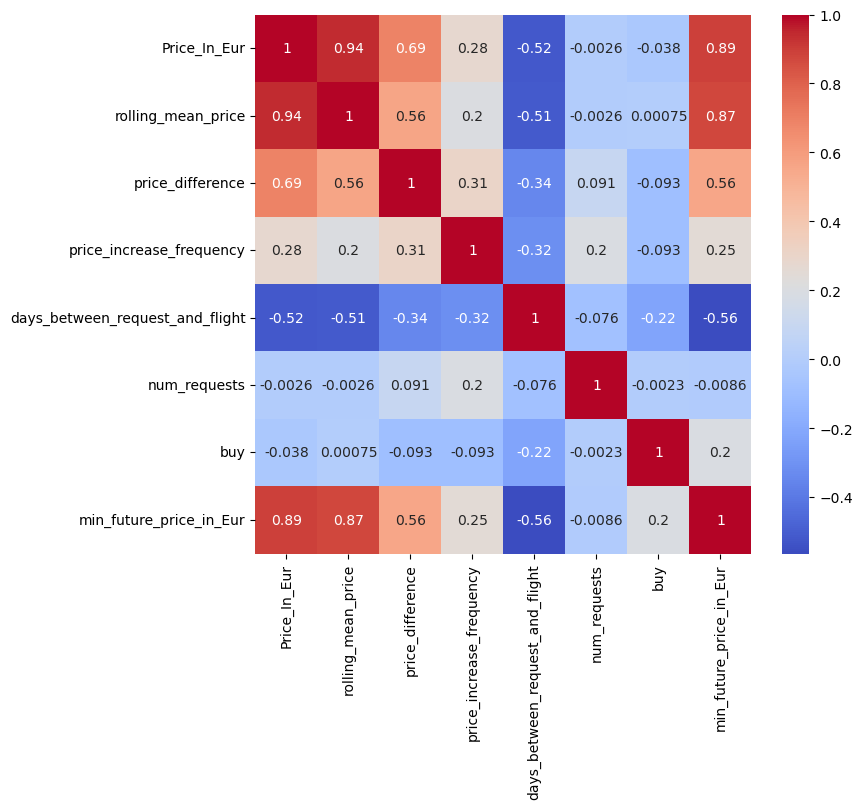

In [45]:
# Plotting correlation matrix
plt.figure(figsize = (8,7))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm")
plt.show()

*Price_In_Eur* is highly correlated with the minimum price which makes sense, because the minimum price and the current requested price most probably are in the same price area. The same is true for *rolling_mean_price*.
*price_defference* also correlates quite strongly with *min_future_price_in_Eur*.
Just as strongly, *days_between_request_and_flight* correlates negatively with *min_future_price_in_Eur*. The *price_increase_frequency* also correlates slightly positively with the *min_future_price_in_Eur*.
*num_requests* does not seem to correlate significantly with *min_future_price_in_Eur* at first glance. We will examine the feature again for its relevance in the Select most important features step.

We can also see from the correlation matrix that all the price columns are correlated. However, since they could all contain valuable information that differs from each other, this is not a criterion for us not to include them in the model.

#### Categorical Features ####

Next, we investigate how the categorial features are correlated with the target variables *buy* and *min_future_price_in_Eur*. Because we already know that the target variables are correlated with each other, we only look at the correlation with *buy*.

In [46]:
# get the categorical features
df_train_copy_cat = df_train_copy[['buy', 'route_abb', 'Departure_airport', 'Arrival_airport', 'Departure_hour', 'Request_Month', 'Request_Day_Of_Week', 'Request_Hour', 'Request_is_Weekend', 'Flight_Month', 'Flight_Day_Of_Week', 'Flight_is_Weekend', 'is_holiday']]

##### **Route** #####

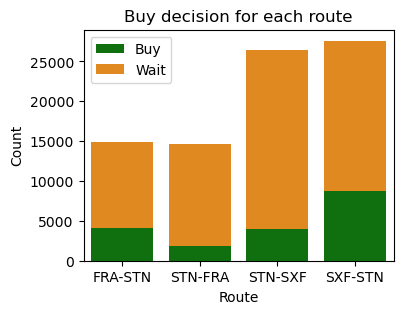

In [47]:
# Check the correlation between route_abb and the target variable 'buy'
buy_route_counts = df_train_copy_cat.groupby(['route_abb', 'buy']).size().unstack()

# Plot the data
plt.figure(figsize=(4, 3))
sns.barplot(x=buy_route_counts.index, y=buy_route_counts[1], label='Buy', color='g')
sns.barplot(x=buy_route_counts.index, y=buy_route_counts[0], bottom=buy_route_counts[1], label='Wait', color='darkorange')

plt.xlabel('Route')
plt.ylabel('Count')
plt.title('Buy decision for each route')
plt.legend()
plt.show()

There seems to be no big influence of the route on the buy decision. Maybe this can be helpful for the prediction.

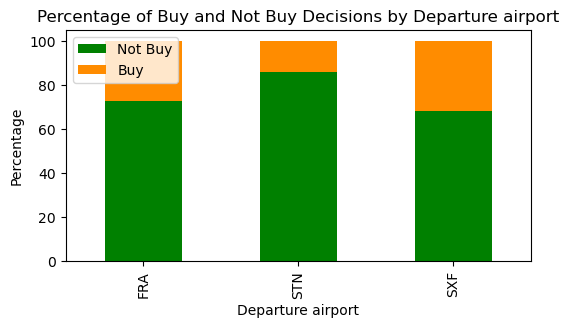

In [48]:
# Calculate the count of 'buy' and 'not buy' decisions for each Departure_airport
buy_counts = df_train_copy_cat.groupby(['Departure_airport', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(6, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Departure airport')
plt.xlabel('Departure airport')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.show()

It seems that there are a bit different amounts of buy-decisions for each Departure airport. Maybe this can be helpful for the prediction.

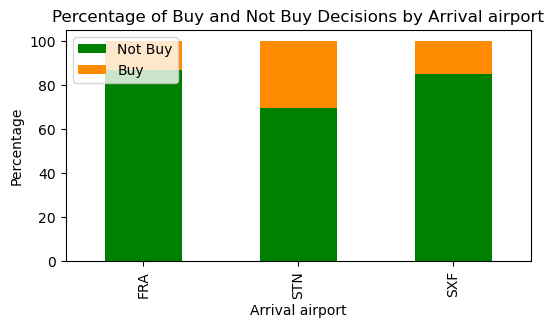

In [49]:
# Calculate the count of 'buy' and 'not buy' decisions for each Arrival_airport
buy_counts = df_train_copy_cat.groupby(['Arrival_airport', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(6, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Arrival airport')
plt.xlabel('Arrival airport')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.show()

It seems that there are a bit different amounts of buy-decisions for each Arrival airport.

##### **Departure time** #####

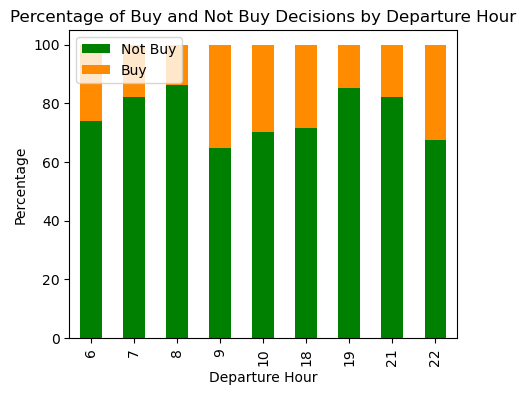

In [50]:
# Check the correlation between Departure_hour and the target variable 'buy'
buy_counts = df_train_copy_cat.groupby(['Departure_hour', 'buy']).size().unstack()

buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Departure Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.show()

It seems that the percentage of buy-reccomendation is higher for departure hours in the late morning as well as the early afternoon and late evening.

##### **Holiday** #####

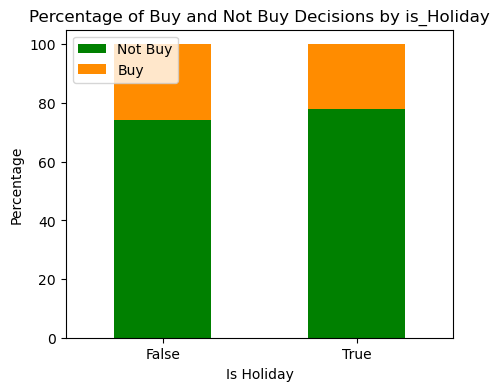

In [51]:
# Calculate the count of 'buy' and 'not buy' decisions for each holiday status
buy_counts = df_train_copy_cat.groupby(['is_holiday', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by is_Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

The proportions of buy-reccomedation and not-buy-reccomedation for the feature is_Holiday seem to be quite the same. Therefore we can't say that this feature is a good predictor for the target variable.

##### **Request Time Data** #####

**Request_Month**

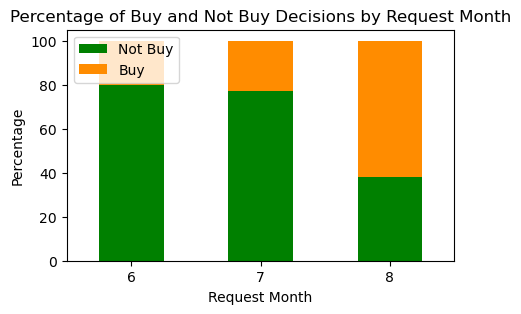

In [52]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_Month
buy_counts = df_train_copy_cat.groupby(['Request_Month', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Request Month')
plt.xlabel('Request Month')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seem to be a higher percentage of buy-decisions for requests made in August. This could be a consequense of the data, which only contains data for flights departing in September latest. But this doesn't have to be the only explanation.

**Request_Day_Of_Week**

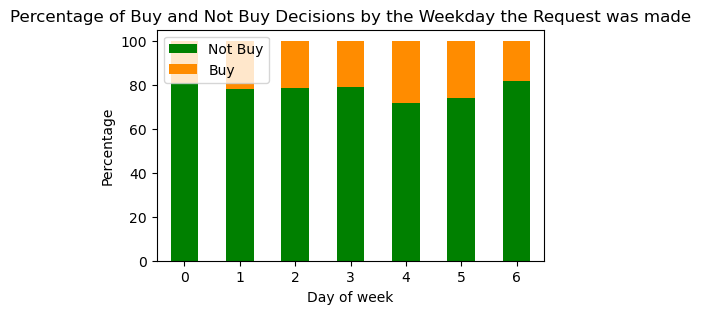

In [53]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_Day_Of_Week
buy_counts = df_train_copy_cat.groupby(['Request_Day_Of_Week', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by the Weekday the Request was made')
plt.xlabel('Day of week')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

**Request_Hour**

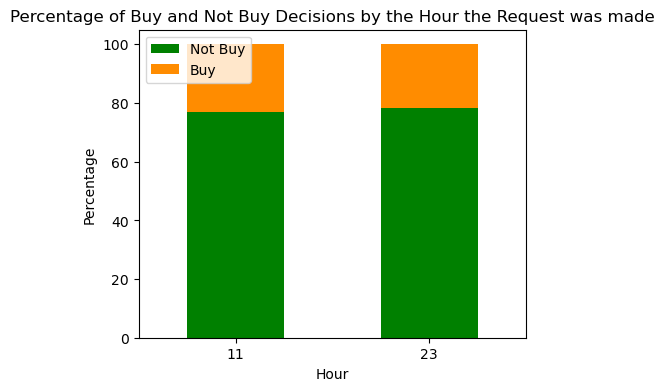

In [54]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_Hour status
buy_counts = df_train_copy_cat.groupby(['Request_Hour', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by the Hour the Request was made')
plt.xlabel('Hour')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

**Request_is_Weekend**

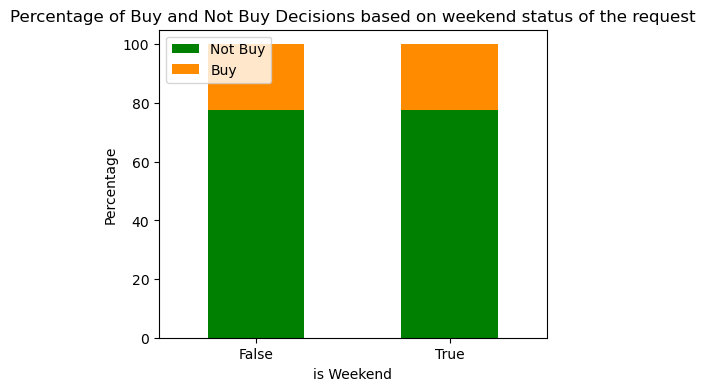

In [55]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_is_Weekend status
buy_counts = df_train_copy_cat.groupby(['Request_is_Weekend', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions based on weekend status of the request')
plt.xlabel('is Weekend')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

##### **Flight Time Data** #####

**Flight_Month**

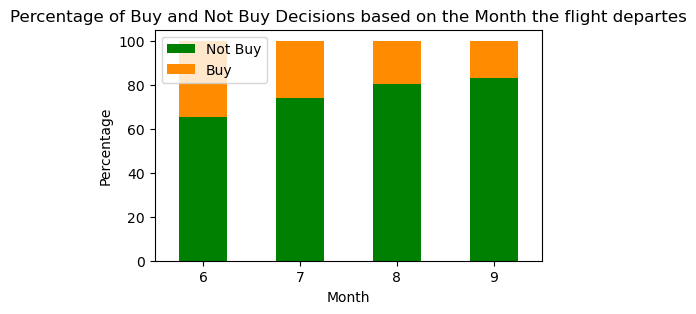

In [56]:
# Calculate the count of 'buy' and 'not buy' decisions for each Flight_Month
buy_counts = df_train_copy_cat.groupby(['Flight_Month', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions based on the Month the flight departes')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be more buy recommendations for flights that departe earlier in the year. This could be due to the fact, that we only have a limited range of months contained in the dataset. Meaning, if we have a Flight departing at June, but we only have data for requests since June, we can't wait to buy the ticket, because the flight starts only a short time after the request. But this doesn't have to be the only reason for this decrease in buy-decisions over the year.

**Flight_Day_Of_Week**

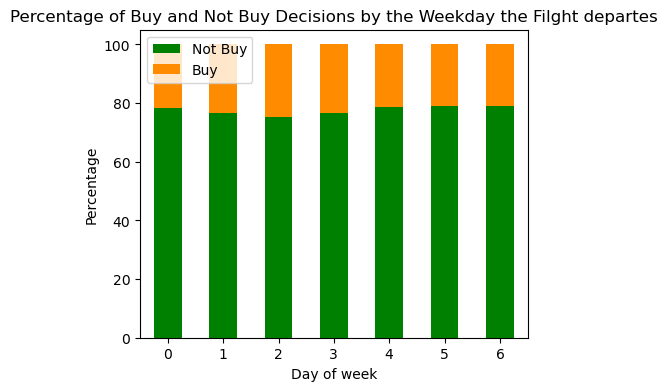

In [57]:
# Calculate the count of 'buy' and 'not buy' decisions for each Flight_Day_Of_Week
buy_counts = df_train_copy_cat.groupby(['Flight_Day_Of_Week', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by the Weekday the Filght departes')
plt.xlabel('Day of week')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

**Flight_is_Weekend**

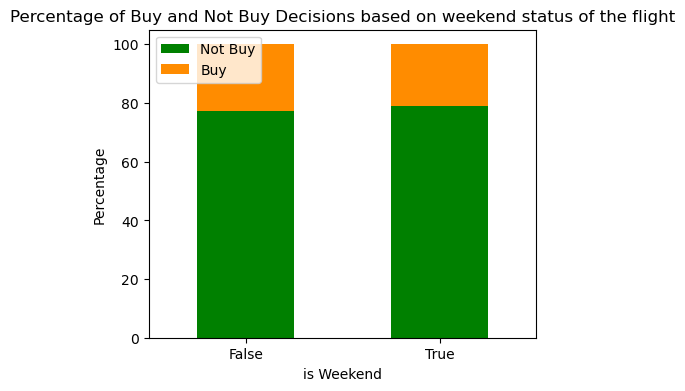

In [58]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_is_Weekend status
buy_counts = df_train_copy_cat.groupby(['Flight_is_Weekend', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions based on weekend status of the flight')
plt.xlabel('is Weekend')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

### Select most important features ###

Now, we have manually inspected the numerical and categoriel features to find features that might be important for the model.

Additionally, we will now use a method to find the most important features for the model based on the results of SelectKBest. SelectKBest takes a function, meaning a statistical test to evaluate the relationship between each feature and the target variable. The function then returns the K best features (K is freely selecteable) based on the results of the statistical test.

Because for regression and classification tasks different evaluation functions are needed, we will perform two separate investigations.

#### SelectKBest for Regression (target variable: min_future_price_in_Eur) ####

In [59]:
# copy the data
df_train_copy_kbest_reg = df_train_copy.copy()

# define the features and the target variable
X = df_train_copy.drop(['buy', 'flight_unique_id', 'route_abb', 'Request_Date', 'Flight_Date', 'min_future_price_in_Eur'], axis=1)
y = df_train_copy['min_future_price_in_Eur']

X = pd.get_dummies(X)

bestfeatures = SelectKBest(score_func=mutual_info_regression, k=20)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # naming the dataframe columns

# print 20 best features
featureScores.nlargest(20,'Score')

,Specs,Score
0,index,5.161714
15,price_difference,3.026201
2,Price_In_Eur,2.812678
13,rolling_mean_price,1.654015
1,Departure_hour,0.797408
17,Departure_airport_STN,0.685798
20,Arrival_airport_STN,0.684207
8,Flight_Day_Of_Week,0.661299
7,Flight_Month,0.568376
10,days_between_request_and_flight,0.564835


#### SelectKBest for Classification (target variable: buy) ####

In [60]:
# copy the data
df_train_copy_kbest_cl = df_train_copy.copy()

# separate the features and the target variable 'min_future_price_in_Eur'
X = df_train_copy_kbest_cl.drop(['buy', 'Request_Date', 'Flight_Date', 'flight_unique_id'], axis=1)
Y = df_train_copy_kbest_cl['buy']

# convert the categorical columns to numerical
X = pd.get_dummies(X)

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif , k=20)
fit = bestfeatures.fit(X, Y)

# create a dataframe with the scores
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat the two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# print the 20 best features
featureScores.nlargest(20, 'Score')


,Specs,Score
0,index,0.276787
16,price_difference,0.227858
3,min_future_price_in_Eur,0.082754
2,Price_In_Eur,0.080095
14,rolling_mean_price,0.055518
11,days_between_request_and_flight,0.035591
22,Departure_airport_STN,0.022823
25,Arrival_airport_STN,0.020255
4,Request_Month,0.015572
20,route_abb_SXF-STN,0.014771


The results of the two SelectKBest-runs align mostly with our previously findings, so we select the following features for our model training:

- *Departure_hour*	
- *Price_In_Eur*	
- *min_future_price_in_Eur*	
- *buy*	
- *days_between_request_and_flight*	
- *flight_is_weekend*	
- *is_holiday*	
- *route_abb*	
- *price_difference*	
- *Flight_Month*	
- *Request_Month*	
- *rolling_mean_price*	
- *price_increase_frequency*	
- *num_requests*

## Prepare the Data for Model Training ##

In this step we apply the knowledge from the previous chapter, i.e. we prepare the data for training by performing the required transformations, deriving features, creating new ones and removing unneeded features.

In [61]:
df_copy = orig_df_train.copy()

In [62]:
def preprocess_dataframe(df):

    # create a copy of the original dataframe
    df_copy = df.copy()

    # Convert 'Price_In_Eur' to whole cents and store as integers to avoid floating point errors.
    df_copy['Price_In_Eur'] = df_copy['Price_In_Eur'] * 100
    df_copy['Price_In_Eur'] = df_copy['Price_In_Eur'].astype(int)

    # Convert 'Request_Date' and 'Flight_Date' to datetime format
    df_copy['Request_Date'] = pd.to_datetime(df_copy['Request_Date'], format='%Y-%m-%dT%H:%M:%SZ')
    df_copy['Flight_Date'] = pd.to_datetime(df_copy['Flight_Date'], format='%Y-%m-%d')

    # Convert 'flight_unique_id' to a numeric format
    df_copy['flight_unique_id'] = df_copy['flight_unique_id'].apply(lambda x: int(''.join(filter(str.isdigit, x))))

    return df_copy

In [63]:
df_copy = preprocess_dataframe(df_copy)

In [64]:
def feature_engineering(df):

    # Make a copy of the dataframe
    df_copy = df.copy()

    # 1. days_between_request_and_flight
    df_copy['days_between_request_and_flight'] = (df_copy['Flight_Date'] - df_copy['Request_Date']).dt.days

    # 2. flight_is_weekend
    df_copy['flight_is_weekend'] = df_copy['Flight_Date'].dt.weekday >= 5
    df_copy['flight_is_weekend'] = df_copy['flight_is_weekend'].astype(int)

    # 3. is_holiday: Flight on holiday vs. not on holiday
    df_copy['is_bank_holiday'] = df_copy['Flight_Date'].apply(is_bank_holiday_uk_ger)
    df_copy['is_vacation'] = is_vacation(df_copy)
    df_copy['is_holiday'] = df_copy['is_bank_holiday'] | df_copy['is_vacation']

    # 4. Encode the route_abb column
    route_abb_encoded = pd.get_dummies(df_copy['route_abb'], prefix='route')
    df_copy = pd.concat([df_copy, route_abb_encoded], axis=1)

    # 5. price_difference
    grouped_prices = df_copy.groupby('flight_unique_id')['Price_In_Eur'].transform('mean')
    df_copy['price_difference'] = df_copy['Price_In_Eur'] - grouped_prices

    # 6. month_flight
    df_copy['month_flight'] = df_copy['Flight_Date'].dt.month

    # 7. month_request
    df_copy['month_request'] = df_copy['Request_Date'].dt.month

    # 8. rolling_mean_price
    df_copy['rolling_mean_price'] = df_copy.groupby('flight_unique_id')['Price_In_Eur'].transform(lambda x: x.rolling(10, min_periods=1).mean())

    # 9. price_increase_frequency
    df_copy['price_increase_frequency'] = df_copy.groupby('flight_unique_id')['Price_In_Eur'].transform(lambda x: (x.diff() > 0).rolling(10, min_periods=1).sum())

    # 10. num_requests: Number of requests per flight
    df_copy['num_requests'] = df_copy.groupby('flight_unique_id').rolling('5D', on='Request_Date')['Request_Date'].count().reset_index(drop=True)
    # Replace NaN values with the mean of the rest of the values in the column
    df_copy['num_requests'].fillna(df_copy['num_requests'].mean(), inplace=True)

    # Convert boolean columns to integer
    for col in df_copy.columns:
        if df_copy[col].dtype == bool:
            df_copy[col] = df_copy[col].astype(int)

    # Drop columns which will not be used in modeling
    df_copy = df_copy.drop(columns=['Flight_Date', 'route_abb', 'index', 'is_vacation', 'is_bank_holiday'])

    return df_copy

In [65]:
df_copy = feature_engineering(df_copy)
df_copy.head()

,Request_Date,Departure_hour,flight_unique_id,Price_In_Eur,min_future_price_in_Eur,buy,days_between_request_and_flight,flight_is_weekend,is_holiday,route_FRA-STN,route_STN-FRA,route_STN-SXF,route_SXF-STN,price_difference,month_flight,month_request,rolling_mean_price,price_increase_frequency,num_requests
0,2019-06-03 11:00:00,19,20190605146,20807,259.07,1,1,0,1,0,0,0,1,-3825.0,6,6,20807.0,0.0,1.0
1,2019-06-03 23:00:00,19,20190605146,25907,259.07,1,1,0,1,0,0,0,1,1275.0,6,6,23357.0,1.0,2.0
2,2019-06-04 11:00:00,19,20190605146,25907,259.07,1,0,0,1,0,0,0,1,1275.0,6,6,24207.0,1.0,3.0
3,2019-06-04 23:00:00,19,20190605146,25907,259.07,1,0,0,1,0,0,0,1,1275.0,6,6,24632.0,1.0,4.0
4,2019-06-03 11:00:00,21,20190605147,14386,251.72,1,1,0,1,0,0,1,0,-8098.0,6,6,14386.0,0.0,1.0


## Model Selection ##

In the model selection phase, we try out different models and optimize their hyperparameters to choose the most suitable machine learning algorithm for our specific problem, based on the outcomes of the data preparation and feature selection process.
<br>
<br>
But before we start with the model training, we have to make clear what the model should predict. Based on the interim presentations and the input we got from them about the project and the approach, we have decided to train 2 different models. The idea is as follows: The final goal is to predict buy, for that we will use a classification model. But to make this decision in the best possible way, it would be helpful to know the min_future_price_in_Eur, so we can say if the ticket will become cheaper. However, since this feature is logically not included in the real data, we will first train a regression model that predicts this value. For practical use, this means that the min_future_price_in_Eur is first predicted for the real data and then the classifier is used on the real data combined with the min_future_price_in_Eur-Prediction to predict buying or not buying. [TODO Quelle Gruppe E]

#### Model Quality Evaluation Function by Prof. Spott ####

To calculate whether a model is good and makes good buy-suggestions, we use a custom metric which was provided by Prof. Dr. Martin Spott. The concept of this quality measurement is at follows:

It could be that 9 times out of 10 we correctly predict that it is best to buy the ticket now. But then the one time we wrongly give a buy recommendation, the ticket price is currently very high and we make a big loss. In contrast, it could be that we have only saved minimally on the 9 correct predictions. This encompasses the model quality evaluation function. [TODO: Quelle Spott]

We will later use it to calculate the quality of our models.

In [66]:
# The model quality evaluation function expects a Pandas dataframe with at least the following columns:
# Request_Date          int64
# flight_unique_id     object
# Price               float64
# buy                    bool

def model_quality_evaluation(df):
    # Make a copy of the provided dataframe as to not modify the original.
    df = df.copy()

    # Convert 'Price' to whole cents and store as integers to avoid floating point errors.
    df['Price'] = df['Price'] * 100
    df['Price'] = df['Price'].astype(int)

    # Initialize a variable that stores the sum of all our balances.
    sum_balances = 0

    # Get a list of all 'flight_unique_id'.
    flight_unique_ids = df['flight_unique_id'].unique()

    # Iterate over all 'flight_unique_id'.
    for flight_unique_id in flight_unique_ids:
        # Get a subset of the data for the specified 'flight_unique_id'.
        df_subset = df[df['flight_unique_id'] == flight_unique_id]

        # Get all request dates except for the latest request date before departure.
        # At the latest request date before departure we need to buy a ticket anyway,
        # so we don't care about this specific request date.
        request_dates = df_subset[df_subset['Request_Date'] != df_subset['Request_Date'].max()]

        # Make sure request dates are sorted in descending order.
        request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)

        # Get the ticket price from the latest request date before departure,
        # because we certainly have to buy a ticket at this date.
        last_buying_price = df_subset[df_subset['Request_Date'] == df_subset['Request_Date'].max()]['Price'].values[0]

        # Iterate over the remaining request dates
        for _, row in request_dates.iterrows():
            # and check wether the model wants to buy a ticket at the specific request date.
            if(row['buy'] == True):
                # If the model decides to buy a ticket the last buying price is set to the
                # price point of this request date and the balance doesn't change.
                last_buying_price = row['Price']
            else:
                # If the models decides to not buy a ticket the balance equals the
                # the current ticket price minus the last buying price.
                current_price = row['Price']
                balance = current_price - last_buying_price

                # The balance is added to the sum of all balances.
                sum_balances = sum_balances + balance

    # Return the sum of all our previously calculated balances.
    return sum_balances / 100

#### Define helper functions for quality evaluation ####

In the model training, we want to investigate different metrics, not only the custom model quality evaluation function we previously defined. <br>

To evaluate the regression models, we will look at the MSE and the R2-score.

We want to look at the classification model's performance in terms of accuracy, precision, recall, roc auc, F1-score and the custom evaluation function score. Additionally, we want to look at the confusion matrix to see how many false positives and false negatives we have. Then we want to look at the learning curve, meaning how the model's performance changes with the number of examples for training and testing. Finally, we want to look at the roc-curve to see how the true positive rate and false positive rate change with the threshold.

For all these metrics, we defined helper functions we can call in the model training easily.

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create a function to calculate the metrics for regression
def calculate_metrics_reg(y_test, y_pred):
    return {
        'mse': round(mean_squared_error(y_test, y_pred), 4),
        'r2': round(r2_score(y_test, y_pred), 4),
        }

In [68]:
# Create a function to calculate the metrics for classification
def calculate_metrics(y_test, y_pred):
    return {
        'acc': accuracy_score(y_test, y_pred),
        'prec': precision_score(y_test, y_pred),
        'rec': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc': roc_auc_score(y_test, y_pred)
    }

# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Create a function to plot the Learning Curve
def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(4, 3))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Create a function to plot the ROC Curve
def plot_roc_curve(estimator, X, y, cv=5):
    # Compute probabilities
    y_pred_prob = estimator.predict_proba(X_test)[:,1]

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(4, 3))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Create a helper function for custom model evaluation score
def custom_score(df, df_orig, y_pred):
  val_df = df.copy()
  val_df['Request_Date'] = df_orig.loc[df.index, 'Request_Date']
  val_df['flight_unique_id'] = df_orig.loc[df.index, 'flight_unique_id']
  val_df['Price'] = df_orig.loc[df.index, 'Price_In_Eur']
  val_df['buy'] = y_pred

  # Sort the DataFrame by 'flight_unique_id' and 'Request_Date' for proper evaluation
  val_df.sort_values(by=['flight_unique_id', 'Request_Date'], inplace=True)

  # Evaluate the model's monetary effectiveness on the test set
  monetary_evaluation_result = model_quality_evaluation(val_df)
  return monetary_evaluation_result / 100

### Model to predict min_future_price_in_Eur ###

#### Define the target variable and the features ####

In [95]:
# Features and target variable
X = df_copy.drop(columns=['buy', 'min_future_price_in_Eur', 'Request_Date'])
y = df_copy['min_future_price_in_Eur']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Scaling ####

Some machine learning algorithms are sensitive to the scale of the input data. For example, algorithms that use a distance measure, such as k-nearest neighbors (KNN) or support vector machines (SVM), can be affected if the features are not on the same scale. But we will use no algorithm that use distance measurements, so we don't need to scale the data.

#### Model Training ####

For the prediction of *min_future_price_in_Eur* we train and evaluate 3 different models to see which one performs best. The 3 Models are [TODO: Quelle Aurelion Geron]:



*   **Linear Regression** <br>
It's a basic and widely-used model that can be trained quickly. It's good for an initial approach to see how well a simple model can perform.
*   **Random Forest Regressor** <br>
Random Forest can capture non-linear relationships in the dataset and is robust to outliers. It also offers good interpretability through feature importances.
*   **Gradient Boosting Regressor** <br>
Gradient Boosting is known for its high performance and ability to model complex non-linear relationships. However, it can be more prone to overfitting and requires careful tuning of hyperparameters.

In [97]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Train the Random Forest Regressor model
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# Train the Gradient Boosting Regressor model
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [98]:
# calculate cross-validation scores
from sklearn.model_selection import cross_validate
from prettytable import PrettyTable


scoring = {'mse': 'neg_mean_squared_error', 'r2': 'r2'}
lr_scores = cross_validate(lr, X_train, y_train, scoring=scoring, cv=5)
rfr_scores = cross_validate(rfr, X_train, y_train, scoring=scoring, cv=5)
gbr_scores = cross_validate(gbr, X_train, y_train, scoring=scoring, cv=5)

# print the mean of the scores in a table
table = PrettyTable()
table.field_names = ['Model', 'MSE', 'R2']

table.add_row(['Linear Regression', round(lr_scores['test_mse'].mean(), 4), round(lr_scores['test_r2'].mean(), 4)])
table.add_row(['Random Forest Regressor', round(rfr_scores['test_mse'].mean(), 4), round(rfr_scores['test_r2'].mean(), 4)])
table.add_row(['Gradient Boosting Regressor', round(gbr_scores['test_mse'].mean(), 4), round(gbr_scores['test_r2'].mean(), 4)])

table

Model,MSE,R2
Linear Regression,-367.8182,0.8286
Random Forest Regressor,-139.8557,0.9348
Gradient Boosting Regressor,-246.9439,0.8849


In [71]:
# Compute the scores for the Linear Regression model
lr_train_pred = lr.predict(X_train)
lr_test_pred = lr.predict(X_test)

lr_train_scores = calculate_metrics_reg(y_train, lr_train_pred)
lr_test_scores = calculate_metrics_reg(y_test, lr_test_pred)


# Compute the scores for the Random Forest Regressor model
rfr_train_pred = rfr.predict(X_train)
rfr_test_pred = rfr.predict(X_test)

rfr_train_scores = calculate_metrics_reg(y_train, rfr_train_pred)
rfr_test_scores = calculate_metrics_reg(y_test, rfr_test_pred)


# Compute the scores for the Gradient Boosting Regressor model
gbr_train_pred = gbr.predict(X_train)
gbr_test_pred = gbr.predict(X_test)

gbr_train_scores = calculate_metrics_reg(y_train, gbr_train_pred)
gbr_test_scores = calculate_metrics_reg(y_test, gbr_test_pred)

In [72]:
# Make a clear table to compare the scores for the 3 models
table = PrettyTable()

# Add columns
table.field_names = ["Model", "Data Set", "Mean Squared Error (MSE)", "R2 Score"]

# Add rows
table.add_row(["Linear Regression", "Train Set", lr_train_scores['mse'], lr_train_scores['r2']])
table.add_row(["Linear Regression", "Test Set", lr_test_scores['mse'], lr_test_scores['r2']])
table.add_row(["Random Forest Regressor", "Train Set", rfr_train_scores['mse'], rfr_train_scores['r2']])
table.add_row(["Random Forest Regressor", "Test Set", rfr_test_scores['mse'], rfr_test_scores['r2']])
table.add_row(["Gradient Boosting Regressor", "Train Set", gbr_train_scores['mse'], gbr_train_scores['r2']])
table.add_row(["Gradient Boosting Regressor", "Test Set", gbr_test_scores['mse'], gbr_test_scores['r2']])

# Print the table
table

Model,Data Set,Mean Squared Error (MSE),R2 Score
Linear Regression,Train Set,367.6324,0.8287
Linear Regression,Test Set,349.1783,0.8299
Random Forest Regressor,Train Set,18.0599,0.9916
Random Forest Regressor,Test Set,113.7582,0.9446
Gradient Boosting Regressor,Train Set,236.878,0.8896
Gradient Boosting Regressor,Test Set,233.1833,0.8864


The Random Forest Regressor achieved the lowest MSE, followed by the Gradient Boosting Regressor and then the Linear Regression model. Additionally, the Random Forest Regressor has also the highest R2 score.
We can see that the scores from the Random Forest Regressor are much better for the training than the test set. This could mean that the model is currently overfitting the data. But nevertheless the scores indicate that the best fit for the data among the three models is the Random Forest Regressor.

Therefore we will optimize the hyperparameters for the **Random Forest Regressor** in the next step.

#### Model Tuning ####

To optimize the hyperparameters we will use an bayesian optimizer, because TODO.

In [100]:
# Initialize the bayesian optimizer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rfr = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  random_state=42)
    return np.mean(cross_val_score(rfr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'max_depth': (3, 50),
    'min_samples_split': (2, 30),
    'min_samples_leaf': (1, 30)
})

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -356.7    | 4.382     | 18.85     | 18.14     | 126.2     |
| 2         | -356.1    | 4.896     | 12.95     | 13.66     | 954.1     |
| 3         | -196.0    | 24.05     | 16.15     | 6.077     | 873.5     |
| 4         | -185.4    | 42.91     | 12.97     | 17.13     | 537.4     |
| 5         | -297.2    | 6.592     | 3.578     | 21.64     | 695.5     |
| 6         | -178.9    | 41.73     | 10.4      | 8.303     | 831.8     |
| 7         | -178.2    | 49.94     | 9.714     | 22.94     | 758.4     |
| 8         | -297.2    | 6.816     | 2.748     | 6.429     | 656.3     |
| 9         | -206.7    | 14.89     | 20.22     | 19.22     | 70.83     |
| 10        | -179.0    | 22.88     | 7.737     | 27.51     | 945.9     |
| 11        | -179.0    | 21.87     | 7.588     | 27.63     | 948.5     |
| 12        | -173.8    | 37.03     | 

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -356.7    | 4.382     | 18.85     | 18.14     | 126.2     |
| 2         | -356.1    | 4.896     | 12.95     | 13.66     | 954.1     |
| 3         | -196.0    | 24.05     | 16.15     | 6.077     | 873.5     |
| 4         | -185.4    | 42.91     | 12.97     | 17.13     | 537.4     |
| 5         | -297.2    | 6.592     | 3.578     | 21.64     | 695.5     |
| 6         | -178.9    | 41.73     | 10.4      | 8.303     | 831.8     |
| 7         | -178.2    | 49.94     | 9.714     | 22.94     | 758.4     |
| 8         | -297.2    | 6.816     | 2.748     | 6.429     | 656.3     |
| 9         | -206.7    | 14.89     | 20.22     | 19.22     | 70.83     |
| 10        | -179.0    | 22.88     | 7.737     | 27.51     | 945.9     |
| 11        | -179.0    | 21.87     | 7.588     | 27.63     | 948.5     |
| 12        | -173.8    | 37.03     | 1.0       | 30.0      | 953.5     |
| 13        | -167.4    | 25.45     | 6.747     | 17.89     | 848.0     |
| 14        | -158.1    | 50.0      | 1.368     | 17.61     | 857.6     |
| 15        | -213.3    | 49.72     | 25.92     | 25.61     | 847.9     |
| 16        | -173.8    | 36.44     | 1.0       | 30.0      | 876.8     |
| 17        | -170.6    | 37.71     | 1.836     | 27.29     | 791.6     |
| 18        | -231.5    | 9.021     | 6.812     | 21.44     | 811.7     |
| 19        | -185.4    | 50.0      | 12.15     | 2.0       | 786.0     |
| 20        | -220.8    | 50.0      | 30.0      | 30.0      | 784.6     |
| 21        | -138.5    | 50.0      | 1.0       | 2.0       | 881.9     |
| 22        | -152.2    | 50.0      | 1.0       | 13.73     | 905.9     |
| 23        | -216.4    | 50.0      | 27.08     | 2.0       | 898.6     |
| 24        | -139.2    | 21.66     | 1.0       | 3.586     | 764.1     |
| 25        | -194.3    | 12.62     | 2.378     | 29.07     | 763.9     |
| 26        | -214.9    | 22.96     | 26.63     | 2.0       | 754.8     |
| 27        | -138.5    | 41.37     | 1.0       | 2.0       | 747.4     |
| 28        | -191.1    | 37.36     | 14.5      | 15.97     | 488.9     |
| 29        | -138.6    | 50.0      | 1.0       | 2.0       | 722.1     |
| 30        | -219.4    | 50.0      | 29.33     | 2.0       | 718.9     |
=========================================================================

In [ ]:
# Initialize the bayesian optimizer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rfr = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  random_state=42)
    return np.mean(cross_val_score(rfr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'max_depth': (3, 50),
    'min_samples_split': (2, 30),
    'min_samples_leaf': (1, 30)
})

# Perform the optimization
optimizer.maximize(n_iter=30, init_points=15)

In [ ]:
# |   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
# -------------------------------------------------------------------------
# | 1         | -208.3    | 21.62     | 22.53     | 9.823     | 534.8     |
# | 2         | -205.2    | 15.93     | 20.01     | 29.44     | 773.5     | !!!
# | 3         | -188.3    | 29.52     | 13.67     | 6.895     | 949.1     | !!!
# | 4         | -171.7    | 49.73     | 8.407     | 11.95     | 159.9     | !!!
# | 5         | -168.9    | 42.56     | 4.701     | 22.59     | 930.2     | !!!
# | 6         | -162.5    | 39.92     | 6.008     | 11.53     | 587.9     | !!!
# | 7         | -172.8    | 29.56     | 3.907     | 27.54     | 203.9     |
# | 8         | -189.6    | 14.55     | 12.54     | 22.11     | 188.7     |
# | 9         | -167.9    | 34.65     | 7.602     | 15.12     | 676.8     |
# | 10        | -188.4    | 42.13     | 13.62     | 4.466     | 356.0     |
# | 11        | -179.4    | 37.14     | 10.93     | 21.93     | 545.6     |
# | 12        | -211.7    | 28.38     | 24.79     | 18.0      | 430.2     |
# | 13        | -274.5    | 7.683     | 18.14     | 3.645     | 180.7     |
# | 14        | -186.0    | 28.96     | 10.63     | 29.64     | 80.21     |
# | 15        | -178.2    | 14.28     | 8.595     | 15.91     | 429.7     |
# | 16        | -170.0    | 41.14     | 4.169     | 23.27     | 932.2     |
# | 17        | -166.4    | 40.45     | 6.723     | 16.84     | 572.5     |
# | 18        | -188.2    | 37.07     | 12.96     | 29.07     | 587.9     |
# | 19        | -138.6    | 50.0      | 1.0       | 2.0       | 578.0     | !!!
# | 20        | -193.7    | 49.44     | 15.66     | 4.138     | 569.1     |
# | 21        | -138.6    | 38.33     | 1.0       | 2.0       | 577.8     | !!!
# | 22        | -142.4    | 24.03     | 2.275     | 5.538     | 572.5     |
# | 23        | -148.0    | 16.33     | 1.0       | 2.0       | 588.8     |
# | 24        | -297.6    | 6.029     | 1.314     | 22.25     | 572.7     |
# | 25        | -198.4    | 23.73     | 17.62     | 3.688     | 583.7     |
# | 26        | -138.6    | 50.0      | 1.0       | 2.0       | 593.1     |

In [ ]:
# Initialize the bayesian optimizer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the function to optimize
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rfr = RandomForestRegressor(n_estimators=int(n_estimators),
                                max_depth=int(max_depth),
                                min_samples_split=int(min_samples_split),
                                min_samples_leaf=int(min_samples_leaf),
                                random_state=42)
    return np.mean(cross_val_score(rfr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

# Initialize the optimizer with new bounds
new_bounds = {
    'n_estimators': (500, 700),
    'max_depth': (40, 60),
    'min_samples_split': (2, 5),
    'min_samples_leaf': (1, 5)
}

# Perform the optimization with new bounds
optimizer = BayesianOptimization(f=optimize, pbounds=new_bounds)
optimizer.maximize(n_iter=30, init_points=15)

In [ ]:
# comment out the code below if you want to run the optimization again
# |   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
# -------------------------------------------------------------------------
# | 1         | -141.6    | 43.82     | 2.886     | 3.824     | 668.2     |
# | 2         | -146.6    | 50.12     | 3.196     | 2.689     | 668.8     |
# | 3         | -152.1    | 58.48     | 4.114     | 3.713     | 659.9     |
# | 4         | -152.1    | 52.13     | 4.948     | 3.869     | 682.0     |

In [107]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': [500, 600, 700],
    'max_depth': [40, 50, 60],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Random search
random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_grid, n_iter=100, cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_params

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
# Definieren der Optimierungsfunktion
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rfr = RandomForestRegressor(n_estimators=int(n_estimators),
                                max_depth=int(max_depth),
                                min_samples_split=int(min_samples_split),
                                min_samples_leaf=int(min_samples_leaf),
                                random_state=42)
    return np.mean(cross_val_score(rfr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

# Setzen der neuen Grenzen für die Hyperparameter
new_bounds = {
    'n_estimators': (700, 900),
    'max_depth': (20, 50),
    'min_samples_split': (2, 6),
    'min_samples_leaf': (1, 5)
}

# Initialisieren des Optimierers mit den neuen Grenzen
new_optimizer = BayesianOptimization(f=optimize, pbounds=new_bounds)

# Durchführen der Optimierung mit den neuen Grenzen
# Sie können die Anzahl der Iterationen und Startpunkte auch erhöhen, wenn Sie möchten
new_optimizer.maximize(n_iter=30, init_points=15)

In [ ]:
# |   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
# -------------------------------------------------------------------------
# | 1         | -152.1    | 33.41     | 4.923     | 4.337     | 838.5     |
# | 2         | -139.4    | 31.0      | 1.707     | 4.359     | 755.4     | !!!
# | 3         | -141.6    | 45.35     | 2.885     | 2.698     | 889.5     |
# | 4         | -139.8    | 20.45     | 1.612     | 3.96      | 887.7     |
# | 5         | -140.3    | 33.18     | 1.068     | 5.187     | 832.0     |
# | 6         | -146.6    | 40.94     | 3.069     | 3.296     | 727.8     |
# | 7         | -152.1    | 43.44     | 4.152     | 4.198     | 739.2     |
# | 8         | -152.1    | 25.18     | 4.365     | 3.276     | 824.1     |
# | 9         | -146.6    | 37.47     | 3.436     | 2.929     | 736.7     |
# | 10        | -146.7    | 24.88     | 3.349     | 2.949     | 875.8     |
# | 11        | -141.6    | 29.84     | 2.19      | 4.072     | 757.9     |
# | 12        | -142.4    | 47.14     | 2.256     | 5.218     | 845.5     |
# | 13        | -139.4    | 24.52     | 1.138     | 4.115     | 768.7     | !!!
# | 14        | -152.1    | 39.19     | 4.85      | 4.585     | 816.7     |
# | 15        | -146.6    | 28.97     | 3.451     | 4.506     | 719.9     |
# | 16        | -139.4    | 26.22     | 1.0       | 4.456     | 765.1     | !!!
# | 17        | -142.5    | 20.95     | 1.0       | 6.0       | 764.9     |
# | 18        | -141.6    | 30.0      | 1.0       | 6.0       | 769.2     |
# | 19        | -141.6    | 28.16     | 1.0       | 6.0       | 750.4     |
# | 20        | -138.5    | 36.03     | 1.0       | 2.0       | 752.9     | !!!
# | 21        | -141.5    | 38.14     | 1.0       | 6.0       | 757.4     |
# | 22        | -157.5    | 32.65     | 5.0       | 2.0       | 750.7     |
# | 23        | -138.7    | 34.83     | 1.0       | 3.349     | 755.8     |
# | 24        | -141.6    | 40.1      | 2.138     | 2.009     | 753.6     |

In [101]:
# Initialize the bayesian optimizer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rfr = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  random_state=42)
    return np.mean(cross_val_score(rfr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'max_depth': (3, 50),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20)
})

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -193.7    | 24.14     | 15.13     | 9.325     | 378.6     |
| 2         | -203.1    | 29.58     | 19.22     | 6.24      | 65.76     |
| 3         | -232.6    | 9.101     | 11.88     | 18.95     | 448.4     |
| 4         | -196.0    | 21.61     | 16.93     | 8.505     | 869.6     |
| 5         | -191.1    | 24.74     | 14.27     | 5.852     | 302.8     |
| 6         | -203.1    | 34.14     | 19.5      | 6.106     | 56.23     |
| 7         | -185.4    | 22.81     | 12.43     | 17.18     | 815.8     |
| 8         | -406.9    | 3.588     | 16.9      | 3.207     | 638.6     |
| 9         | -250.4    | 8.518     | 7.259     | 6.134     | 326.0     |
| 10        | -182.2    | 23.08     | 11.65     | 18.94     | 787.9     |
| 11        | -204.6    | 50.0      | 20.0      | 6.291     | 234.1     |
| 12        | -162.3    | 50.0      | 

In [ ]:
# optimizer = BayesianOptimization(f=optimize, pbounds={
#     'n_estimators': (10, 1000),
#     'max_depth': (3, 50),
#     'min_samples_split': (2, 10),
#     'min_samples_leaf': (1, 10)
# })

# |   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
# -------------------------------------------------------------------------
# | 1         | -140.5    | 47.44     | 1.19      | 5.552     | 451.8     |
# | 2         | -171.4    | 32.08     | 8.798     | 3.935     | 239.2     |
# | 3         | -167.2    | 34.21     | 7.845     | 5.478     | 376.4     |
# | 4         | -146.6    | 47.58     | 3.958     | 4.823     | 816.4     |
# | 5         | -162.6    | 44.65     | 6.318     | 4.796     | 241.8     |
# | 6         | -322.9    | 5.647     | 4.033     | 2.97      | 579.5     |
# | 7         | -150.6    | 38.55     | 3.092     | 9.486     | 204.1     |
# | 8         | -146.6    | 31.59     | 3.121     | 6.92      | 663.7     |
# | 9         | -406.6    | 3.355     | 6.925     | 5.345     | 951.4     |
# | 10        | -142.7    | 45.6      | 2.177     | 3.652     | 92.1      |
# | 11        | -152.1    | 47.43     | 4.182     | 6.039     | 817.6     |
# | 12        | -138.6    | 50.0      | 1.0       | 2.0       | 744.7     | !!!
# | 13        | -406.5    | 3.0       | 10.0      | 10.0      | 10.0      |
# | 14        | -406.6    | 3.0       | 1.0       | 2.0       | 776.0     |
# | 15        | -178.9    | 50.0      | 10.0      | 2.0       | 702.9     |
# | 16        | -142.3    | 48.83     | 2.391     | 4.213     | 143.7     |
# | 17        | -407.2    | 3.0       | 10.0      | 10.0      | 128.8     |
# | 18        | -169.4    | 16.89     | 7.285     | 9.353     | 422.8     |
# | 19        | -212.7    | 10.02     | 1.0       | 2.0       | 474.8     |
# | 20        | -406.9    | 3.0       | 1.0       | 10.0      | 690.2     |
# | 21        | -138.8    | 50.0      | 1.0       | 2.0       | 415.1     |
# | 22        | -178.9    | 50.0      | 10.0      | 2.0       | 638.6     |
# | 23        | -153.3    | 48.0      | 4.194     | 9.953     | 296.1     |
# | 24        | -170.4    | 13.54     | 1.0       | 2.0       | 325.3     |
# | 25        | -406.8    | 3.0       | 10.0      | 10.0      | 281.9     |
# | 26        | -140.6    | 50.0      | 1.0       | 5.297     | 333.9     |

In [ ]:
# Initialize the bayesian optimizer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rfr = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  random_state=42)
    return np.mean(cross_val_score(rfr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'max_depth': (3, 100),
    'min_samples_split': (2, 40),
    'min_samples_leaf': (1, 40)
})

# Perform the optimization
optimizer.maximize(n_iter=15, init_points=10)

In [ ]:
# |   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
# -------------------------------------------------------------------------
# | 1         | -208.3    | 85.67     | 22.35     | 36.99     | 575.2     |
# | 2         | -183.4    | 84.18     | 5.282     | 36.57     | 421.3     | !!!
# | 3         | -200.6    | 17.97     | 18.83     | 29.33     | 256.9     |
# | 4         | -230.1    | 67.23     | 37.13     | 11.73     | 242.1     |
# | 5         | -223.6    | 93.42     | 32.25     | 30.76     | 705.1     |
# | 6         | -204.1    | 14.67     | 19.73     | 2.361     | 281.7     |
# | 7         | -173.2    | 37.96     | 4.111     | 24.15     | 38.79     | !!!
# | 8         | -214.9    | 89.3      | 26.69     | 31.94     | 834.5     |
# | 9         | -173.8    | 71.95     | 1.023     | 30.36     | 953.6     |
# | 10        | -217.9    | 99.6      | 28.33     | 22.05     | 568.3     |
# | 11        | -298.6    | 6.317     | 1.0       | 38.94     | 10.0      |
# | 12        | -182.1    | 80.19     | 4.84      | 36.55     | 415.9     |
# | 13        | -165.2    | 54.35     | 5.722     | 16.49     | 53.7      | !!!
# | 14        | -200.1    | 70.9      | 17.04     | 28.24     | 32.67     |
# | 15        | -204.2    | 73.27     | 19.0      | 26.65     | 30.94     |
# | 16        | -179.4    | 38.96     | 1.0       | 35.09     | 73.84     |
# | 17        | -210.6    | 31.13     | 23.34     | 2.0       | 63.74     |
# | 18        | -172.8    | 66.17     | 1.0       | 29.43     | 989.8     |
# | 19        | -152.2    | 99.99     | 1.0       | 13.49     | 977.2     | !!!
# | 20        | -219.4    | 87.98     | 29.18     | 2.0       | 975.4     |
# | 21        | -182.9    | 100.0     | 1.0       | 40.0      | 978.4     |
# | 22        | -163.1    | 99.6      | 2.723     | 20.03     | 944.7     |
# | 23        | -146.6    | 91.5      | 3.288     | 6.167     | 915.4     | !!!

#### Retrain model ####

In [77]:
# Retrain regressor with best params to predict min_future_price_in_Eur

# # Train a RandomForest regressor
rf_regressor = RandomForestRegressor(
    n_estimators = 744,
    max_depth = 50,
    min_samples_split = 2,
    min_samples_leaf = 1
)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, n_estimators=744)

In [99]:
# Compute the scores for the Random Forest Regressor model
rfr_train_pred = rfr.predict(X_train)
rfr_test_pred = rfr.predict(X_test)

rfr_train_scores = calculate_metrics_reg(y_train, rfr_train_pred)
rfr_test_scores = calculate_metrics_reg(y_test, rfr_test_pred)

print("Train set scores:", rfr_train_scores)
print("Test set scores:", rfr_test_scores)

scoring = {'mse': 'neg_mean_squared_error', 'r2': 'r2'}
rfr_scores = cross_validate(rfr, X_train, y_train, scoring=scoring, cv=5)

# print the mean of the cv-scores
print('Random Forest Regressor', round(rfr_scores['test_mse'].mean(), 4), round(rfr_scores['test_r2'].mean(), 4))


Train set scores: {'mse': 18.0599, 'r2': 0.9916}
Test set scores: {'mse': 113.7582, 'r2': 0.9446}
Random Forest Regressor -139.8557 0.9348


### Model to predict buy ###

Now, we have trained a Random Forest Regressor to predict *min_future_price_in_Eur*. Let's move on with the training of the Classifier.
For the Training we will use the correct *min_future_price_in_Eur*, not the predicted ones, so we learn on the most precise data as possible and don't train on data, which containes errors.

#### Define the target variable and the features ####

In [80]:
features = [
    'Departure_hour', 'flight_unique_id', 'Price_In_Eur',
    'min_future_price_in_Eur', 'days_between_request_and_flight', 'flight_is_weekend',
    'is_holiday', 'route_FRA-STN', 'route_STN-FRA', 'route_STN-SXF', 'route_SXF-STN',
    'price_difference', 'month_flight', 'month_request', 'rolling_mean_price',
    'price_increase_frequency', 'num_requests'
]
target = 'buy'

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_copy[features], df_copy[target], test_size=0.2, random_state=42)

#### Model Training ####

For the classification model, we will look at 5 different Classifiers, compare them, optimize the 3 most promising ones and then select the best ones. [TODO: Quelle einfügen Geron]

*   **Logistic Regression** <br>
As a straightforward algorithm, Logistic Regression serves as a good starting point. It's interpretable and can give probabilities alongside classifications, which could be useful for understanding the model's confidence in its decisions.
*   **Random Forest Classifier** <br>
Random Forests can handle both linear and non-linear data and provide feature importances. They are also less prone to overfitting compared to Decision Trees. The ensemble nature makes it robust and versatile for classification tasks.
*   **Gradient Boosting Classifier** <br>
Gradient Boosting generally performs well for binary classification tasks like this one. It's great for imbalanced datasets and can model complex relationships. However, it may require more time for hyperparameter tuning.
*   **XGBoost Classifier** <br>
XGBoost is known for its high predictive performance and speed. It handles imbalanced datasets well and includes built-in regularization to prevent overfitting. It offers flexibility to define custom optimization objectives and is highly tunable.
*   **MLPClassifier**: TODO, falls genutzt



In [ ]:
# for RandomForestClassifier
# class_weight='balanced' to account for the imbalanced dataset

# for XGBoost
# calculate the ratio of the positive and negative class
# ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
# clf = xgb.XGBClassifier(scale_pos_weight=ratio)

# for AdaBoost
# use SMOTE to oversample the minority class
# smote = SMOTE(sampling_strategy='auto')
# X_res, y_res = smote.fit_resample(X_train, y_train)
# clf = AdaBoostClassifier(n_estimators=50)
# clf.fit(X_res, y_res)

In [81]:
# Ensure all non-numeric columns are properly encoded or dropped
X_train = X_train.select_dtypes(include=[np.number])

# Train a Logistic Regression Classifier
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Train a RandomForest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Train a XGBoost Classifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Train a GradientBoosting Classifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# Train a MLP Classifier
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

# Train a AdaBoost Classifier
abc = AdaBoostClassifier(random_state=42)
abc.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [82]:
# make predictions and calculate evaluation scores
lr_pred = lr.predict(X_test)
lr_scores = calculate_metrics(y_test, lr_pred)
custom_score_lr = custom_score(X_test, df_copy, lr_pred)

rfc_pred = rfc.predict(X_test)
rfc_scores = calculate_metrics(y_test, rfc_pred)
custom_score_rfc = custom_score(X_test, df_copy, rfc_pred)

xgb_pred = xgb.predict(X_test)
xgb_scores = calculate_metrics(y_test, xgb_pred)
custom_score_xgb = custom_score(X_test, df_copy, xgb_pred)

gbc_pred = gbc.predict(X_test)
gbc_scores = calculate_metrics(y_test, gbc_pred)
custom_score_gbc = custom_score(X_test, df_copy, gbc_pred)

mlp_pred = mlp.predict(X_test)
mlp_scores = calculate_metrics(y_test, mlp_pred)
custom_score_mlp = custom_score(X_test, df_copy, mlp_pred)

abc_pred = abc.predict(X_test)
abc_scores = calculate_metrics(y_test, abc_pred)
custom_score_abc = custom_score(X_test, df_copy, abc_pred)

d:\Programme\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sbene\AppData\Local\Temp\ipykernel_50472\916293602.py:52: RuntimeWarning: overflow encountered in long_scalars
  sum_balances = sum_balances + balance
d:\Programme\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sbene\AppData\Local\Temp\ipykernel_50472\916293602.py:52: RuntimeWarning: overflow encountered in long_scalars
  sum_balances = sum_balances + balance


In [83]:
# Make a clear table to compare the scores for the 5 models
table = PrettyTable()

# Add columns
table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1", "ROC AUC", "Custom Score"]

# Add rows
table.add_row(["LogisticRegression", lr_scores['acc'], lr_scores['prec'], lr_scores['rec'], lr_scores['f1'], lr_scores['roc'], custom_score_lr])
table.add_row(["RandomForestClassifier", rfc_scores['acc'], rfc_scores['prec'], rfc_scores['rec'],  rfc_scores['f1'], rfc_scores['roc'], custom_score_rfc])
table.add_row(["XGBClassifier", xgb_scores['acc'], xgb_scores['prec'], xgb_scores['rec'], xgb_scores['f1'], xgb_scores['roc'], custom_score_xgb])
table.add_row(["GradientBoostingClassifier", gbc_scores['acc'], gbc_scores['prec'], gbc_scores['rec'], gbc_scores['f1'], gbc_scores['roc'], custom_score_gbc])
table.add_row(["MLPClassifier", mlp_scores['acc'], mlp_scores['prec'], mlp_scores['rec'], mlp_scores['f1'], mlp_scores['roc'], custom_score_mlp])
table.add_row(["AdaBoostClassifier", abc_scores['acc'], abc_scores['prec'], abc_scores['rec'], abc_scores['f1'], abc_scores['roc'], custom_score_abc])

# Print the table
table

Model,Accuracy,Precision,Recall,F1,ROC AUC,Custom Score
LogisticRegression,0.7744095665171898,0.0,0.0,0.0,0.5,67890.5692
RandomForestClassifier,0.9826606875934231,0.9725915875169606,0.9499072356215214,0.9611155805846071,0.9710546060751215,15331.81
XGBClassifier,0.9919282511210762,0.9802006335797254,0.9840975351179433,0.9821452188863907,0.989153461814685,30109.9
GradientBoostingClassifier,0.9524663677130045,0.9550733496332519,0.8282533792737874,0.8871540099361248,0.9084518903780919,-30418.99
MLPClassifier,0.7744095665171898,0.0,0.0,0.0,0.5,67890.5692
AdaBoostClassifier,0.8938116591928251,0.8963874553394204,0.5984627617280679,0.7177368086458995,0.7891557168739166,-135934.84


### Model Tuning ###

#### RandomForestClassifier ####

In [84]:
# Initialize the bayesian optimizer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rfc = RandomForestClassifier(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  random_state=42)
    return np.mean(cross_val_score(rfc, X_train, y_train, cv=5, scoring='f1'))

# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'max_depth': (3, 50),
    'min_samples_split': (2, 50),
    'min_samples_leaf': (1, 50)
})

# Perform the optimization
optimizer.maximize(n_iter=15, init_points=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.3962    | 6.397     | 28.21     | 47.23     | 534.9     |
| 2         | 0.75      | 12.15     | 32.72     | 28.69     | 537.0     |
| 3         | 0.8558    | 35.25     | 22.69     | 20.65     | 461.2     |
| 4         | 0.9133    | 43.61     | 8.859     | 9.15      | 376.5     |
| 5         | 0.8243    | 37.7      | 32.84     | 30.69     | 413.1     |
| 6         | 0.7995    | 29.37     | 39.13     | 21.39     | 125.3     |
| 7         | 0.6255    | 9.229     | 27.98     | 38.33     | 845.5     |
| 8         | 0.8311    | 43.2      | 29.52     | 8.459     | 268.3     |
| 9         | 0.7948    | 44.04     | 44.37     | 41.75     | 963.8     |
| 10        | 0.8278    | 19.05     | 31.75     | 47.68     | 511.6     |
| 11        | 0.7848    | 42.02     | 47.41     | 43.78     | 961.9     |
| 12        | 0.9019    | 42.3      | 

AttributeError: 'BayesianOptimization' object has no attribute 'best_params_'

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.3962    | 6.397     | 28.21     | 47.23     | 534.9     |
| 2         | 0.75      | 12.15     | 32.72     | 28.69     | 537.0     | !!!
| 3         | 0.8558    | 35.25     | 22.69     | 20.65     | 461.2     | !!!
| 4         | 0.9133    | 43.61     | 8.859     | 9.15      | 376.5     | !!!
| 5         | 0.8243    | 37.7      | 32.84     | 30.69     | 413.1     |
| 6         | 0.7995    | 29.37     | 39.13     | 21.39     | 125.3     |
| 7         | 0.6255    | 9.229     | 27.98     | 38.33     | 845.5     |
| 8         | 0.8311    | 43.2      | 29.52     | 8.459     | 268.3     |
| 9         | 0.7948    | 44.04     | 44.37     | 41.75     | 963.8     |
| 10        | 0.8278    | 19.05     | 31.75     | 47.68     | 511.6     |
| 11        | 0.7848    | 42.02     | 47.41     | 43.78     | 961.9     |
| 12        | 0.9019    | 42.3      | 10.58     | 13.63     | 363.1     |
| 13        | 0.8634    | 39.86     | 19.38     | 21.69     | 376.2     |
| 14        | 0.9406    | 28.55     | 1.009     | 14.29     | 372.5     | !!!
| 15        | 0.8331    | 22.55     | 29.19     | 45.92     | 511.0     |
| 16        | 0.88      | 23.21     | 15.31     | 2.0       | 370.1     |
| 17        | 0.9221    | 23.05     | 6.535     | 14.48     | 391.9     |
| 18        | 0.4903    | 7.417     | 1.0       | 27.7      | 377.2     |
| 19        | 0.9297    | 39.89     | 5.346     | 3.736     | 398.1     |
| 20        | 0.8545    | 27.91     | 22.25     | 2.0       | 396.4     |
| 21        | 0.9522    | 27.52     | 1.954     | 3.397     | 383.4     | !!!
| 22        | 0.9251    | 44.03     | 1.0       | 25.03     | 396.5     |
| 23        | 0.9372    | 46.43     | 3.418     | 11.56     | 421.7     |
| 24        | 0.919     | 25.78     | 5.078     | 19.19     | 422.5     |
| 25        | 0.9524    | 32.35     | 1.0       | 2.0       | 442.6     | !!!
=========================================================================

#### XGBClassifier ####

In [87]:
# Initialize the bayesian optimizer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# optimizable params for XGBClassifier	
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

# Define the function to optimize
def optimize(n_estimators, max_depth, learning_rate, min_child_weight, gamma, subsample, colsample_bytree):
    xgb = XGBClassifier(n_estimators=int(n_estimators),
                        max_depth=int(max_depth),
                        learning_rate=learning_rate,
                        min_child_weight=int(min_child_weight),
                        gamma=gamma,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        random_state=42)
    return np.mean(cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1'))

# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'max_depth': (3, 50),
    'learning_rate': (0.01, 0.5),
    'min_child_weight': (1, 10),
    'gamma': (0, 0.5),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1)
})
# Perform the optimization
optimizer.maximize(n_iter=15, init_points=10)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9666    | 0.9136    | 0.3351    | 0.2554    | 29.99     | 8.199     | 14.53     | 0.8894    |
| 2         | 0.982     | 0.9088    | 0.4538    | 0.4151    | 4.499     | 4.337     | 953.3     | 0.9184    |
| 3         | 0.9817    | 0.9937    | 0.2062    | 0.02053   | 46.99     | 6.119     | 862.2     | 0.8633    |
| 4         | 0.9815    | 0.8299    | 0.221     | 0.2198    | 49.93     | 7.83      | 858.7     | 0.9022    |
| 5         | 0.9811    | 0.8088    | 0.3605    | 0.1993    | 26.07     | 7.434     | 854.6     | 0.9274    |
| 6         | 0.9842    | 0.8548    | 0.3244    | 0.1829    | 21.67     | 2.968     | 837.4     | 0.863     |
| 7         | 0.9835    | 0.8089    | 0.4482    | 0.2354    | 36.47     | 3.505     | 463.8     | 0.9781    |
| 8       

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9666    | 0.9136    | 0.3351    | 0.2554    | 29.99     | 8.199     | 14.53     | 0.8894    |
| 2         | 0.982     | 0.9088    | 0.4538    | 0.4151    | 4.499     | 4.337     | 953.3     | 0.9184    | !!!
| 3         | 0.9817    | 0.9937    | 0.2062    | 0.02053   | 46.99     | 6.119     | 862.2     | 0.8633    |
| 4         | 0.9815    | 0.8299    | 0.221     | 0.2198    | 49.93     | 7.83      | 858.7     | 0.9022    |
| 5         | 0.9811    | 0.8088    | 0.3605    | 0.1993    | 26.07     | 7.434     | 854.6     | 0.9274    |
| 6         | 0.9842    | 0.8548    | 0.3244    | 0.1829    | 21.67     | 2.968     | 837.4     | 0.863     |!!!
| 7         | 0.9835    | 0.8089    | 0.4482    | 0.2354    | 36.47     | 3.505     | 463.8     | 0.9781    |
| 8         | 0.9827    | 0.9033    | 0.2257    | 0.06205   | 37.81     | 7.728     | 421.3     | 0.9729    |
| 9         | 0.9812    | 0.9034    | 0.1221    | 0.3583    | 5.168     | 3.002     | 838.7     | 0.8977    |
| 10        | 0.9818    | 0.9458    | 0.2259    | 0.116     | 23.3      | 5.014     | 755.5     | 0.8316    |
| 11        | 0.9837    | 1.0       | 0.4209    | 0.01      | 48.5      | 1.0       | 803.0     | 0.8       |
| 12        | 0.9793    | 0.8139    | 0.1919    | 0.4832    | 5.589     | 9.435     | 525.1     | 0.9354    |
| 13        | 0.9646    | 0.8929    | 0.2072    | 0.1012    | 4.075     | 4.162     | 346.6     | 0.8242    |
| 14        | 0.9844    | 0.9088    | 0.0       | 0.01      | 50.0      | 1.0       | 1e+03     | 0.8       |!!!
| 15        | 0.9819    | 0.8358    | 0.08509   | 0.2467    | 49.38     | 4.121     | 653.5     | 0.8597    |
| 16        | 0.9832    | 0.815     | 0.2551    | 0.2303    | 49.76     | 5.66      | 177.5     | 0.9983    |
| 17        | 0.9589    | 0.8       | 0.0       | 0.5       | 3.0       | 5.658     | 139.8     | 0.8       |
| 18        | 0.9801    | 1.0       | 0.5       | 0.4975    | 50.0      | 10.0      | 232.2     | 1.0       |
| 19        | 0.9816    | 1.0       | 0.0       | 0.4271    | 50.0      | 1.0       | 933.2     | 0.8       |
| 20        | 0.9693    | 0.897     | 0.2506    | 0.1384    | 3.8       | 3.567     | 606.3     | 0.8949    |
| 21        | 0.9825    | 0.9446    | 0.07226   | 0.2317    | 49.84     | 4.068     | 707.8     | 0.8773    |
| 22        | 0.9812    | 0.9977    | 0.08548   | 0.3578    | 4.914     | 3.617     | 997.9     | 0.8065    |
| 23        | 0.9773    | 0.8       | 0.5       | 0.5       | 3.0       | 10.0      | 696.5     | 1.0       |
| 24        | 0.9749    | 1.0       | 0.0       | 0.5       | 3.0       | 10.0      | 451.8     | 0.8       |
| 25        | 0.9814    | 0.8       | 0.0       | 0.5       | 50.0      | 1.0       | 509.4     | 0.8       |
=============================================================================================================

#### GradientBoostingClassifier ####

In [88]:
# Initialize the bayesian optimizer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    gbc = GradientBoostingClassifier(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  random_state=42)
    return np.mean(cross_val_score(gbc, X_train, y_train, cv=5, scoring='f1'))

# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'max_depth': (3, 50),
    'min_samples_split': (2, 50),
    'min_samples_leaf': (1, 50)
})

# Perform the optimization
optimizer.maximize(n_iter=15, init_points=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9797    | 18.77     | 46.48     | 41.96     | 600.5     |
| 2         | 0.9821    | 11.97     | 21.75     | 32.09     | 919.3     |
| 3         | 0.9833    | 10.24     | 6.978     | 28.87     | 529.2     |
| 4         | 0.981     | 9.701     | 48.69     | 4.979     | 871.8     |
| 5         | 0.9805    | 29.49     | 33.89     | 29.94     | 921.2     |
| 6         | 0.983     | 19.43     | 3.338     | 40.46     | 468.6     |
| 7         | 0.9739    | 7.953     | 36.93     | 18.4      | 157.5     |


KeyboardInterrupt: 

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9797    | 18.77     | 46.48     | 41.96     | 600.5     |
| 2         | 0.9821    | 11.97     | 21.75     | 32.09     | 919.3     | !!!
| 3         | 0.9833    | 10.24     | 6.978     | 28.87     | 529.2     | !!!
| 4         | 0.981     | 9.701     | 48.69     | 4.979     | 871.8     |
| 5         | 0.9805    | 29.49     | 33.89     | 29.94     | 921.2     |
| 6         | 0.983     | 19.43     | 3.338     | 40.46     | 468.6     |
| 7         | 0.9739    | 7.953     | 36.93     | 18.4      | 157.5     |

#### AdaBoostClassifier ####

In [92]:
# Initialize the bayesian optimizer
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score


# Define the function to optimize
def optimize(n_estimators, learning_rate):
    abc = AdaBoostClassifier(n_estimators=int(n_estimators),
                                  learning_rate=learning_rate,
                                  random_state=42)
    return np.mean(cross_val_score(abc, X_train, y_train, cv=5, scoring='f1'))

# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'learning_rate': (0.01, 0.5)
}, random_state=42)

# Perform the optimization
optimizer.maximize(n_iter=15, init_points=10)

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 1         | 0.8747    | 0.1935    | 951.2     |
| 2         | 0.9001    | 0.3687    | 602.7     |
| 3         | 0.1655    | 0.08645   | 164.4     |
| 4         | 0.4254    | 0.03846   | 867.5     |
| 5         | 0.8962    | 0.3045    | 711.0     |
| 6         | 0.2463    | 0.02009   | 970.2     |
| 7         | 0.7731    | 0.4179    | 220.2     |
| 8         | 0.2569    | 0.09909   | 191.6     |
| 9         | 0.7223    | 0.1591    | 529.5     |
| 10        | 0.6608    | 0.2217    | 298.3     |
| 11        | 0.9169    | 0.5       | 603.9     |
| 12        | 0.9168    | 0.3368    | 935.5     |
| 13        | 0.0458    | 0.01      | 628.5     |
| 14        | 0.8968    | 0.3043    | 725.7     |
| 15        | 0.08098   | 0.01      | 917.4     |
| 16        | 0.9084    | 0.3499    | 740.6     |
| 17        | 0.785     | 0.1463    | 756.8     |
| 18        | 0.1502    | 0.02009   | 693.5     |


|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 1         | 0.8747    | 0.1935    | 951.2     |
| 2         | 0.9001    | 0.3687    | 602.7     | !!!
| 3         | 0.1655    | 0.08645   | 164.4     |
| 4         | 0.4254    | 0.03846   | 867.5     |
| 5         | 0.8962    | 0.3045    | 711.0     |
| 6         | 0.2463    | 0.02009   | 970.2     |
| 7         | 0.7731    | 0.4179    | 220.2     |
| 8         | 0.2569    | 0.09909   | 191.6     |
| 9         | 0.7223    | 0.1591    | 529.5     |
| 10        | 0.6608    | 0.2217    | 298.3     |
| 11        | 0.9169    | 0.5       | 603.9     | !!!
| 12        | 0.9168    | 0.3368    | 935.5     |
| 13        | 0.0458    | 0.01      | 628.5     |
| 14        | 0.8968    | 0.3043    | 725.7     |
| 15        | 0.08098   | 0.01      | 917.4     |
| 16        | 0.9084    | 0.3499    | 740.6     |
| 17        | 0.785     | 0.1463    | 756.8     |
| 18        | 0.1502    | 0.02009   | 693.5     |
| 19        | 0.5584    | 0.1972    | 237.1     |
| 20        | 0.8804    | 0.2462    | 774.7     |
| 21        | 0.759     | 0.1263    | 789.2     |
| 22        | 0.7826    | 0.1942    | 550.4     |
| 23        | 0.8871    | 0.3416    | 569.0     |
| 24        | 0.9174    | 0.5       | 582.8     | !!!
| 25        | 0.6327    | 0.1227    | 503.1     |
=================================================

### Model Evaluation ###

In [315]:
# Create a copy of the original dataframe
test_df_copy = orig_df_test.copy()

In [316]:
# preprocess test set
test_df_copy = preprocess_dataframe(test_df_copy)

# feature engineering
test_df_copy = feature_engineering(test_df_copy)

test_df_copy.head()

,Request_Date,Departure_hour,flight_unique_id,Price_In_Eur,days_between_request_and_flight,flight_is_weekend,is_holiday,route_FRA-STN,route_STN-FRA,route_STN-SXF,route_SXF-STN,month_flight,month_request,rolling_mean_price,price_increase_frequency,num_requests
0,2019-06-03 11:00:00,7,20190702145,3032,28,0,1,0,0,1,0,7,6,3032.000000,0.0,1.0
1,2019-06-03 23:00:00,7,20190702145,4453,28,0,1,0,0,1,0,7,6,3742.500000,1.0,2.0
2,2019-06-04 11:00:00,7,20190702145,4447,27,0,1,0,0,1,0,7,6,3977.333333,1.0,3.0
3,2019-06-04 23:00:00,7,20190702145,4447,27,0,1,0,0,1,0,7,6,4094.750000,1.0,4.0
4,2019-06-05 11:00:00,7,20190702145,4452,26,0,1,0,0,1,0,7,6,4166.200000,2.0,5.0


In [317]:
# Rearrange columns to match the order of the training data
# 1. get order of columns from training data
order = list(df_copy.columns)
order.remove('min_future_price_in_Eur')
order.remove('buy')
# 2. rearrange columns in test data
test_df_copy = test_df_copy[order]

predicted_min_future_prices = rfr.predict(test_df_copy.drop(columns=['Request_Date']))
test_df_copy['min_future_price_in_Eur'] = predicted_min_future_prices

# rearrange columns to match the order of the training data
order = list(df_copy.columns)
order.remove('buy')
test_df_copy = test_df_copy[order]

predicted_buy = rfc.predict(test_df_copy.drop(columns=['Request_Date']))
test_df_copy['buy'] = predicted_buy

In [318]:
# Rename 'Price_In_Eur' column to 'Price'
test_df_copy = test_df_copy.rename(columns={'Price_In_Eur': 'Price'})

# Apply the quality evaluation function to the test dataset
quality_score = model_quality_evaluation(test_df_copy)

In [319]:
# Rescale and Interpret the Score

# The quality score is in cents. Convert it to Euros for better readability.
quality_score_eur = quality_score / 100
print(f"Quality Score in Euros: {quality_score_eur}")

# 31542.71
# 39856.7 - mit rolling_mean
# 28404.24 - mit price trend
# 39948.39 - ohne rolling_mean
# 41743.4 - mit is_vacation
# 31668.32 - mit is_holiday mit flight is weekday
# 24657.56 - ohne is_holiday mit flight is weekday
# 35735.72 - mit is_holiday mit flight is weekday mit request month
# -6813.14 - mit is_holiday mit flight is weekday mit request month, rolling mean price diff
# 25020.28 - ohne num_requests
# 35735.72 - mit num_requests

Quality Score in Euros: -19969.72
